In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, methylation_motifs, mutation_clocks,utils
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import statsmodels.formula.api as smf


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [ ]:
my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']
order = ['All', 'CESC', 'COAD', 'LGG', 'THCA', 'UCEC', 'BRCA', 'LIHC']
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5_new"

# Read TCGA

In [ ]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
all_mut_w_age_annot_df = pd.read_csv("/cellar/users/zkoch/methylation_and_mutation/data/final_tcga_data/PANCAN_mut_annot.tsv.gz", sep = "\t")

# tissue counts and mut counts

In [ ]:
chosen_dsets = order[1:]

In [ ]:
all_mut_w_age_df['dataset'].value_counts().reset_index().query("index in @chosen_dsets")

In [ ]:
all_methyl_age_df_t['dataset'].value_counts().reset_index().query("index in @chosen_dsets")

In [ ]:
mean_mut_count = all_mut_w_age_df['dataset'].value_counts()/all_methyl_age_df_t['dataset'].value_counts()
mean_mut_count.sort_values(ascending=False, inplace=True)
mean_mut_count.reset_index().query("index in @chosen_dsets")

In [ ]:
mean_mut_count = all_mut_w_age_df['dataset'].value_counts()/all_methyl_age_df_t['dataset'].value_counts()
sample_count = all_methyl_age_df_t['dataset'].value_counts()
combined_df = pd.concat([mean_mut_count, sample_count], axis=1)
combined_df.columns = ['mean_mut_count', 'sample_count']
combined_df['is_chosen_dset'] = combined_df.index.isin(chosen_dsets)

sns.boxplot(x='is_chosen_dset', y='mean_mut_count', data=combined_df.reset_index())

In [ ]:
combined_df.reset_index().groupby('is_chosen_dset')['sample_count'].describe()

In [ ]:
sns.boxplot(x='is_chosen_dset', y='sample_count', data=combined_df.reset_index())


In [ ]:
sns.boxplot(x='is_chosen_dset', y='mean_mut_count', data=combined_df.reset_index().query("sample_count >= 286"))


# Read pancan clock and existing clocks

### pancan

In [91]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

In [5]:
# read in 
chosen_dsets = ['BRCA', 'CESC','COAD','LGG', 'LIHC', 'THCA', 'UCEC']

mut_clock_tcga_hunnidk_all_tenkb_pancan_big = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_burden_feat_10kb_window", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.load_all_mut_burden_df()
# read in mut count df
#mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_chosen_cpg_burden_w_pred_5CV.parquet")
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

"""mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'dataset':'tissue'}, inplace = True)"""
# reads in results dfs and calculates new burdens of clock d
"""mut_clock_tcga_hunnidk_all_tenkb_pancan_big.calculate_burdens_of_clock_cpgs_pancan(
    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_enet*",
    all_mut_w_age_df = all_mut_w_age_df
    )"""

'mut_clock_tcga_hunnidk_all_tenkb_pancan_big.calculate_burdens_of_clock_cpgs_pancan(\n    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_enet*",\n    all_mut_w_age_df = all_mut_w_age_df\n    )'

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.to_parquet(
    "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet"
    )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.calculate_burdens_of_clock_cpgs_pancan(
    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_enet*",
    all_mut_w_age_df = all_mut_w_age_df
    )

### Hannum, horvath, pheno

In [ ]:
sorted_dset_counts = all_methyl_age_df_t['dataset'].value_counts()
chosen_dsets = sorted_dset_counts[sorted_dset_counts > 100].index.tolist()

mut_clock_tcga_hunnidk_all_tenkb_hannum = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_burden_feat_10kb_window", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_tcga_hunnidk_all_tenkb_hannum.load_all_mut_burden_df()

mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/hannum/pred_results_df.parquet")
mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df.rename(columns = {'cv_num': 'cv_number', 'actual_age':'age_at_index'}, inplace = True)
mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df.set_index('sample', inplace = True)
# merge with all_methyl_age_df_t to get tissue
mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df.merge(all_methyl_age_df_t[['dataset']], left_index = True, right_index = True).rename(columns = {'dataset': 'tissue'})

mut_clock_tcga_hunnidk_all_tenkb_hannum.calculate_burdens_of_clock_cpgs_pancan(
    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/hannum/*pkl", all_mut_w_age_df = all_mut_w_age_df
    )

# all used CpGs 
all_clock_cpgs = []
for clock_cpgs in mut_clock_tcga_hunnidk_all_tenkb_hannum.clock_cpgs_by_tissue.values():
    all_clock_cpgs.extend(clock_cpgs)
all_clock_cpgs = list(set(all_clock_cpgs))
# from mut_clock_tcga_hunnidk_all_tenkb_hannum.all_mut_burden_df[all_clock_cpgs] add to mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df
mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df.merge(mut_clock_tcga_hunnidk_all_tenkb_hannum.all_mut_burden_df[all_clock_cpgs], how = 'left', left_index = True, right_index = True)

mut_clock_tcga_hunnidk_all_tenkb_hannum.mutational_age_prediction(
    target = 'pred_age', output_col_label = 'soMepi_age', include_tissue_covariate = False, include_wg_burden_covariate = False,
        just_clock_cpgs = True
    )

In [ ]:
sorted_dset_counts = all_methyl_age_df_t['dataset'].value_counts()
chosen_dsets = sorted_dset_counts[sorted_dset_counts > 100].index.tolist()

mut_clock_tcga_hunnidk_all_tenkb_phenoage = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_burden_feat_10kb_window", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_tcga_hunnidk_all_tenkb_phenoage.load_all_mut_burden_df()

mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/phenoage/pred_results_df.parquet")
mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df.rename(columns = {'cv_num': 'cv_number', 'actual_age':'age_at_index'}, inplace = True)
mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df.set_index('sample', inplace = True)
# merge with all_methyl_age_df_t to get tissue
mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df.merge(all_methyl_age_df_t[['dataset']], left_index = True, right_index = True).rename(columns = {'dataset': 'tissue'})

mut_clock_tcga_hunnidk_all_tenkb_phenoage.calculate_burdens_of_clock_cpgs_pancan(
    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/phenoage/*pkl", all_mut_w_age_df = all_mut_w_age_df
    )

# all used CpGs 
all_clock_cpgs = []
for clock_cpgs in mut_clock_tcga_hunnidk_all_tenkb_phenoage.clock_cpgs_by_tissue.values():
    all_clock_cpgs.extend(clock_cpgs)
all_clock_cpgs = list(set(all_clock_cpgs))
# from mut_clock_tcga_hunnidk_all_tenkb_hannum.all_mut_burden_df[all_clock_cpgs] add to mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df
mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df.merge(mut_clock_tcga_hunnidk_all_tenkb_phenoage.all_mut_burden_df[all_clock_cpgs], how = 'left', left_index = True, right_index = True)

mut_clock_tcga_hunnidk_all_tenkb_phenoage.mutational_age_prediction(
    target = 'pred_age', output_col_label = 'soMepi_age', include_tissue_covariate = False, include_wg_burden_covariate = False,
        just_clock_cpgs = True
    )

In [ ]:
sorted_dset_counts = all_methyl_age_df_t['dataset'].value_counts()
chosen_dsets = sorted_dset_counts[sorted_dset_counts > 100].index.tolist()

mut_clock_tcga_hunnidk_all_tenkb_horvath = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_burden_feat_10kb_window", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_tcga_hunnidk_all_tenkb_horvath.load_all_mut_burden_df()

mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/horvath/pred_results_df.parquet")
mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df.rename(columns = {'cv_num': 'cv_number', 'actual_age':'age_at_index'}, inplace = True)
mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df.set_index('sample', inplace = True)
# merge with all_methyl_age_df_t to get tissue
mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df.merge(all_methyl_age_df_t[['dataset']], left_index = True, right_index = True).rename(columns = {'dataset': 'tissue'})

mut_clock_tcga_hunnidk_all_tenkb_horvath.calculate_burdens_of_clock_cpgs_pancan(
    model_fns_glob = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/retrained_clocks/horvath/*pkl", all_mut_w_age_df = all_mut_w_age_df
    )

# all used CpGs 
all_clock_cpgs = []
for clock_cpgs in mut_clock_tcga_hunnidk_all_tenkb_horvath.clock_cpgs_by_tissue.values():
    all_clock_cpgs.extend(clock_cpgs)
all_clock_cpgs = list(set(all_clock_cpgs))
# from mut_clock_tcga_hunnidk_all_tenkb_hannum.all_mut_burden_df[all_clock_cpgs] add to mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df
mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df.merge(mut_clock_tcga_hunnidk_all_tenkb_horvath.all_mut_burden_df[all_clock_cpgs], how = 'left', left_index = True, right_index = True)

mut_clock_tcga_hunnidk_all_tenkb_horvath.mutational_age_prediction(
    target = 'age_at_index', output_col_label = 'soMepi_age', include_tissue_covariate = False, include_wg_burden_covariate = True,
    just_clock_cpgs = False
    )

# New clock modelling

### Binarized mutations

In [5]:
# read in binarized mut count version
# read in 
chosen_dsets = ['BRCA', 'CESC','COAD','LGG', 'LIHC', 'THCA', 'UCEC']

mut_clock_binary = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_burden_feat_10kb_window_bin", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_binary.load_all_mut_burden_df()
mut_clock_binary.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_10kbWindow_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")
# drop columns of mut_clock_binary.all_mut_burden_df that are all zero
"""mut_clock_binary.all_mut_burden_df = mut_clock_binary.all_mut_burden_df.loc[:, (mut_clock_binary.all_mut_burden_df != 0).any(axis=0)]
# add covariates
mut_clock_binary.all_mut_burden_df['tissue'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t['dataset'])
mut_clock_binary.all_mut_burden_df['gender'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t['gender'])
mut_clock_binary.all_mut_burden_df['age_at_index'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t['age_at_index'])
# drop sampes with no methyl 
mut_clock_binary.all_mut_burden_df.dropna(inplace=True)

mut_counts = mut_clock_binary.all_mut_burden_df.sum(axis=0)
# drop tissue, gender, age_at_index rows
mut_counts = mut_counts.iloc[:-3]
mut_counts.describe()
mut_counts = mut_counts.sort_values(ascending=False)

cols_to_keep = mut_counts.iloc[:100000].index.tolist()
# add back tissue, gender, age_at_index
cols_to_keep.extend(['tissue', 'gender', 'age_at_index'])

mut_clock_binary.all_mut_burden_df = mut_clock_binary.all_mut_burden_df[cols_to_keep]

mut_clock_binary.all_mut_burden_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_10kbWindow_binarized/allTissues_chosencpg_burden.parquet")"""

'mut_clock_binary.all_mut_burden_df = mut_clock_binary.all_mut_burden_df.loc[:, (mut_clock_binary.all_mut_burden_df != 0).any(axis=0)]\n# add covariates\nmut_clock_binary.all_mut_burden_df[\'tissue\'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t[\'dataset\'])\nmut_clock_binary.all_mut_burden_df[\'gender\'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t[\'gender\'])\nmut_clock_binary.all_mut_burden_df[\'age_at_index\'] = mut_clock_binary.all_mut_burden_df.index.map(all_methyl_age_df_t[\'age_at_index\'])\n# drop sampes with no methyl \nmut_clock_binary.all_mut_burden_df.dropna(inplace=True)\n\nmut_counts = mut_clock_binary.all_mut_burden_df.sum(axis=0)\n# drop tissue, gender, age_at_index rows\nmut_counts = mut_counts.iloc[:-3]\nmut_counts.describe()\nmut_counts = mut_counts.sort_values(ascending=False)\n\ncols_to_keep = mut_counts.iloc[:100000].index.tolist()\n# add back tissue, gender, age_at_index\ncols_to_keep.extend([\'tissue\', \'gender\', 

In [8]:
mut_clock_binary.mut_count_w_pred_results_df.set_index('case_submitter_id', inplace = True)
mut_clock_binary.mut_count_w_pred_results_df.rename(columns = {'pred_age':'methyl_age_xgb'}, inplace = True)

In [10]:
mean_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].mean()
median_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].median()
std_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].std()
wg_burden = all_mut_w_age_annot_df.groupby('case_submitter_id')['DNA_VAF'].count()
mut_clock_binary.mut_count_w_pred_results_df['mean_vaf'] = mut_clock_binary.mut_count_w_pred_results_df.index.map(mean_vaf_by_samples)
mut_clock_binary.mut_count_w_pred_results_df['median_vaf'] = mut_clock_binary.mut_count_w_pred_results_df.index.map(median_vaf_by_samples)
mut_clock_binary.mut_count_w_pred_results_df['std_vaf'] = mut_clock_binary.mut_count_w_pred_results_df.index.map(std_vaf_by_samples)
mut_clock_binary.mut_count_w_pred_results_df['std_vaf'].fillna(0, inplace = True)
mut_clock_binary.mut_count_w_pred_results_df['sum'] = mut_clock_binary.mut_count_w_pred_results_df.iloc[:, :100000].sum(axis=1)
mut_clock_binary.mut_count_w_pred_results_df['wg_burden']  = mut_clock_binary.mut_count_w_pred_results_df.index.map(wg_burden)
mut_clock_binary.mut_count_w_pred_results_df['wg_burden_log'] = np.log(mut_clock_binary.mut_count_w_pred_results_df['wg_burden'] + 1)

In [69]:
corr_df = mut_clock_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue')[
    ['age_at_index', 'wg_burden', 'sum','mean_vaf']
    ].corr(method = 'spearman').reset_index()
corr_df.rename(columns = {'#id':'id', }, inplace = True)
corr_df.query("id == 'age_at_index'").sort_values('wg_burden', ascending=False)

#id,tissue,id,age_at_index,wg_burden,sum,mean_vaf
36,LGG,age_at_index,1.0,0.595109,0.492872,0.015456
76,THCA,age_at_index,1.0,0.499831,0.316941,0.062647
32,KIRP,age_at_index,1.0,0.477337,0.409516,0.033611
28,KIRC,age_at_index,1.0,0.461057,0.341924,0.084930
80,THYM,age_at_index,1.0,0.423928,0.316126,0.183346
56,PCPG,age_at_index,1.0,0.420386,0.308341,0.127720
64,SARC,age_at_index,1.0,0.404907,0.376436,-0.039884
20,GBM,age_at_index,1.0,0.348427,0.310364,0.042789
60,PRAD,age_at_index,1.0,0.299957,0.254235,0.105310
12,COAD,age_at_index,1.0,0.258513,0.263708,0.211381


### Create CpG only

In [25]:
mut_wide_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices/tcga_mut_w_age_wide_df_chr10.parquet")

In [46]:
cpg_mut_burden = cpg_mut_w_age_annot_df.groupby('case_submitter_id').count()['DNA_VAF']

In [52]:
#cpg_mut_burden = cpg_mut_burden.to_frame()
cpg_mut_burden.rename(columns = {'DNA_VAF':'cpg_mut_burden'}, inplace = True)
cpg_mut_burden['age'] = cpg_mut_burden.index.map(all_methyl_age_df_t['age_at_index'])
cpg_mut_burden['tissue'] = cpg_mut_burden.index.map(all_methyl_age_df_t['dataset'])
cpg_corr = cpg_mut_burden.groupby('tissue').corr(method = 'spearman').reset_index()
cpg_corr = cpg_corr.query("level_1 == 'age'").sort_values('cpg_mut_burden', ascending=False)
corr_df = corr_df.query("id == 'age_at_index'").sort_values('wg_burden', ascending=False)
corr_df = corr_df.merge(cpg_corr, left_on = 'tissue', right_on = 'tissue')

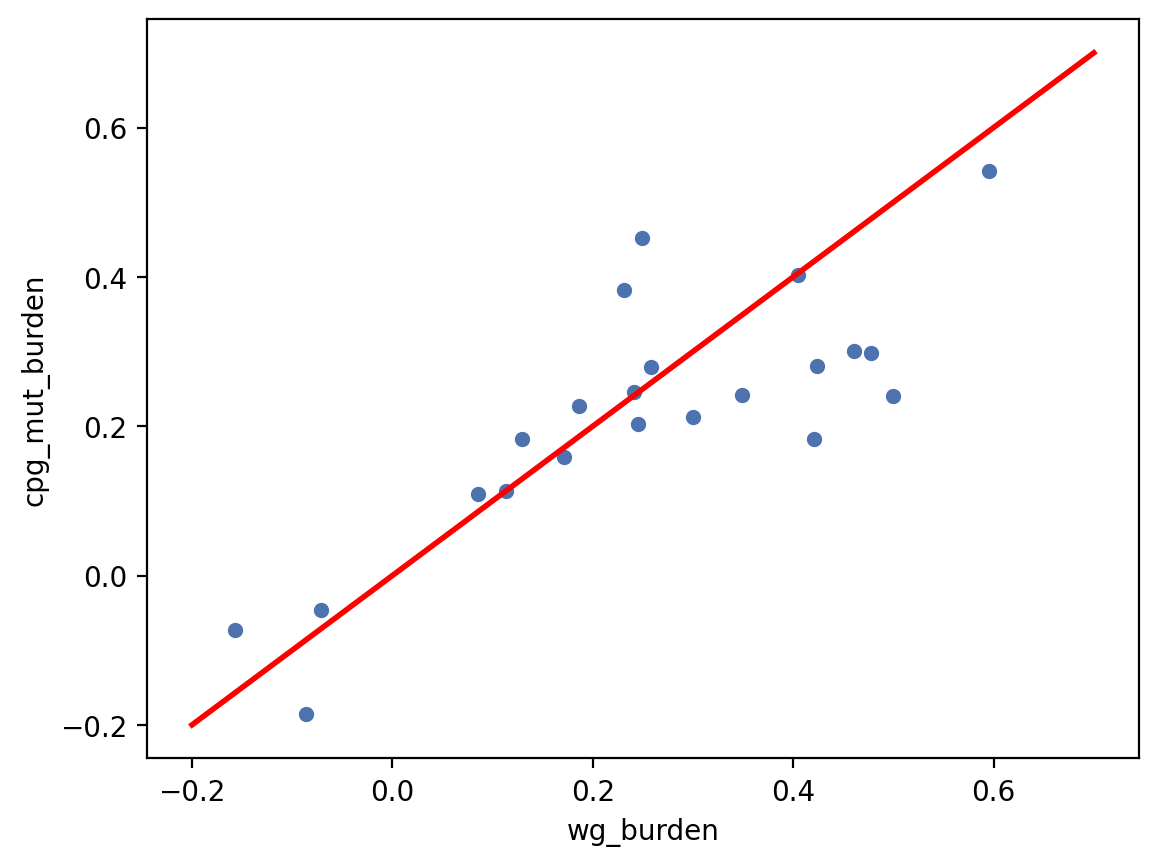

In [80]:
sns.scatterplot(data = corr_df, x = 'wg_burden', y = 'cpg_mut_burden')
# plot y=  x
plt.plot([-.2, 0.7], [-.2, 0.7], linewidth=2, color='red')

In [ ]:
cpg_mut_w_age_annot_df = all_mut_w_age_annot_df.query("cpg_before_mut == True and (mutation == 'C>T' or mutation == 'G>A')")
all_cpg_muts_df = []
for chrom in range(1,23):
    this_chrom_muts = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_mut_wide_matrices/tcga_mut_w_age_wide_df_chr{chrom}.parquet")
    chrom = str(chrom)
    cpg_muts = cpg_mut_w_age_annot_df.query("chr == @chrom")['mut_loc'].unique()
    shared_cpg_muts = list(set(this_chrom_muts.columns) & set(cpg_muts))
    this_chrom_cpg_muts = this_chrom_muts[shared_cpg_muts]
    this_chrom_cpg_muts.to_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_cpg_mut_wide_matrices/tcga_mut_w_age_wide_df_chr{chrom}.parquet")
    all_cpg_muts_df.append(this_chrom_cpg_muts)
    print(chrom, flush = True)

In [119]:
# read in 20 kb burden files 
chosen_dsets = ['BRCA', 'CESC','COAD','LGG', 'LIHC', 'THCA', 'UCEC']

mut_clock_cpg_binary = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_CpG_mut_burden_feat_20kb_window_bin", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_cpg_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_cpg_binary.load_all_mut_burden_df()

mut_clock_cpg_binary.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")


In [123]:
chosen_cpg_burden_df = mut_clock_cpg_binary.all_mut_burden_df

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
# select this tissue's samples and the chose CpGs from the methyl df 
non_cpg_burden_cols = ['wg_burden', 'clock_burden', 'sum','age_at_index','gender','test','weights','dataset','tissue']
cpgs = list(set(chosen_cpg_burden_df.columns).difference(non_cpg_burden_cols))

samples = chosen_cpg_burden_df.index.tolist()
cpgs_w_methyl = list(set(cpgs).intersection(all_methyl_age_df_t.columns))
methyl_df = all_methyl_age_df_t.loc[samples, cpgs_w_methyl]
# get labels
y = all_methyl_age_df_t.loc[samples, 'age_at_index']
# do the cross validation, balancing by age
cv_num = 0
all_preds = []
is_test_sample = []
cv_number = []
for train_index, test_index in skf.split(methyl_df, y):
        is_test_sample.append([False if i in train_index else True for i in range(len(samples))])
        # add the CV number to the list
        cv_number.append([cv_num] * len(samples))
        cv_num += 1
        
all_preds = [item for sublist in all_preds for item in sublist]
is_test_sample = [item for sublist in is_test_sample for item in sublist]
cv_number = [item for sublist in cv_number for item in sublist]
# concatenate 5 copies of the burden df to itself, to match the length of the predictions
all_chosen_cpg_burden_df = pd.concat(
        [chosen_cpg_burden_df] * 5, ignore_index = False).reset_index(
        drop = False
        )

The least populated class in y has only 1 members, which is less than n_splits=5.


### CpG only clocks

In [6]:
# read in 20 kb burden files 
chosen_dsets = ['BRCA', 'CESC','COAD','LGG', 'LIHC', 'THCA', 'UCEC']

mut_clock_cpg_binary = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = all_methyl_age_df_t,
    mut_burden_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_CpG_mut_burden_feat_20kb_window_bin", 
    corr_dir = "",
    mutation_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/tcga_cpg_mut_wide_matrices", 
    consoritum = "tcga",
    tissues = chosen_dsets,
    max_dist = 10000
)
mut_clock_cpg_binary.load_all_mut_burden_df()

mut_clock_cpg_binary.mut_count_w_pred_results_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")
mut_clock_cpg_binary.calc_outliers()

In [190]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.to

#id,case_submitter_id,cg16397722,cg06365412,cg10792831,cg22949073,cg02087342,cg12041075,cg13468400,cg18198734,cg12041429,...,bottom_outlier_bound,is_outlier,mutation_clock_all_feats_wg_logwg_allTissues_noOutliers,mutation_clock_all_feats_wg_logwg_allTissues_topMIAcrossTissues,methyl_clock_resid,mut_clock_resid,mut_clock_resid_bin,pred_age,age_bin,mut_clock_bin
0,TCGA-05-4384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-396.275737,False,65.366745,65.508430,1.066612,-0.502495,NaN,67.066612,NaN,NaN
1,TCGA-05-4390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-396.275737,False,63.327690,63.431717,-0.163551,5.145130,NaN,57.836449,NaN,NaN
2,TCGA-05-4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-396.275737,False,62.693020,62.665798,-1.367241,-13.177212,NaN,74.632759,NaN,NaN
3,TCGA-05-4405,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-396.275737,False,68.141846,65.814590,-0.774834,-8.154480,NaN,73.225166,NaN,NaN
4,TCGA-05-4410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-396.275737,True,-1.000000,63.903473,-0.902138,1.223511,NaN,61.097862,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37535,TCGA-XF-AAN8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-435.964124,False,58.059967,-1.000000,-2.920731,-16.602451,NaN,71.079269,NaN,NaN
37536,TCGA-KC-A4BO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-789.361408,False,58.043461,-1.000000,-0.806744,3.614330,NaN,54.193256,NaN,NaN
37537,TCGA-FP-8209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1283.534099,False,49.758484,-1.000000,-0.548904,0.727455,NaN,48.451096,NaN,NaN
37538,TCGA-HZ-7924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3052.453412,False,62.239811,-1.000000,1.511604,3.388592,NaN,61.511604,NaN,NaN


In [196]:
mut_clock_cpg_binary.mut_count_w_pred_results_df = mut_clock_cpg_binary.mut_count_w_pred_results_df.iloc[:, :-4]

In [197]:
mut_clock_cpg_binary.mut_count_w_pred_results_df

#id,case_submitter_id,cg16397722,cg06365412,cg10792831,cg22949073,cg02087342,cg12041075,cg13468400,cg18198734,cg12041429,...,mutation_clock_all_feats_wg_logwg_PRAD,tissue_mean_wg_burden,tissue_std_wg_burden,top_outlier_bound,bottom_outlier_bound,is_outlier,mutation_clock_all_feats_wg_logwg_allTissues_noOutliers,mutation_clock_all_feats_wg_logwg_allTissues_topMIAcrossTissues,methyl_clock_resid,mut_clock_resid
0,TCGA-05-4384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,383.935927,390.105832,1164.147590,-396.275737,False,65.366745,65.508430,1.066612,-0.502495
1,TCGA-05-4390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,383.935927,390.105832,1164.147590,-396.275737,False,63.327690,63.431717,-0.163551,5.145130
2,TCGA-05-4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,383.935927,390.105832,1164.147590,-396.275737,False,62.693020,62.665798,-1.367241,-13.177212
3,TCGA-05-4405,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.000000,383.935927,390.105832,1164.147590,-396.275737,False,68.141846,65.814590,-0.774834,-8.154480
4,TCGA-05-4410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,383.935927,390.105832,1164.147590,-396.275737,True,-1.000000,63.903473,-0.902138,1.223511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37535,TCGA-XF-AAN8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,342.160099,389.062111,1120.284321,-435.964124,False,58.059967,-1.000000,-2.920731,-16.602451
37536,TCGA-KC-A4BO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.733234,60.347561,424.854484,910.056530,-789.361408,False,58.043461,-1.000000,-0.806744,3.614330
37537,TCGA-FP-8209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,419.391192,851.462645,2122.316482,-1283.534099,False,49.758484,-1.000000,-0.548904,0.727455
37538,TCGA-HZ-7924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,173.045714,1612.749563,3398.544841,-3052.453412,False,62.239811,-1.000000,1.511604,3.388592


In [199]:
# use pyarrow to save
mut_clock_cpg_binary.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

In [ ]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

In [87]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.set_index('index', inplace = True)
mut_clock_cpg_binary.mut_count_w_pred_results_df.drop(columns = ['level_0'], inplace = True)

In [ ]:
mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_allTissues',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = []
        )
#mut_clock_cpg_binary.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_top7',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = top7
        )
mut_clock_cpg_binary.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

for i in range(len(top7)):
        mut_clock_cpg_binary.mutational_age_prediction(
                target = 'age_at_index', output_col_label = f'mutation_clock_all_feats_wg_logwg_{top7[i]}',
                include_tissue_covariate = False, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
                just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
                tissue_subset = [top7[i]]
        )
mut_clock_cpg_binary.mut_count_w_pred_results_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/allTissueschosencpg_burden_w_pred_5CV_xgb.parquet")

mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = [], drop_outliers = True
        )

In [70]:
# compare methyl and mut clocks 
methyl_maes = mut_clock_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue').apply(
        lambda x: mean_absolute_error(x['age_at_index'], x['pred_age'])
        ).reset_index().rename(columns = {0: 'mae'})
methyl_maes['metric'] = 'mae'

# mae of age_at_index and mutation_clock_all_feats_wg_logwg_top7_newcv0
mut_maes = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and is_outlier == False").groupby(
    'tissue').apply(
        lambda x: mean_absolute_error(x['age_at_index'], x['mutation_clock_all_feats_wg_logwg_allTissues'])
        ).reset_index().rename(columns = {0: 'mae'})
mut_maes['metric'] = 'mae'

methyl_r = mut_clock_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue')[['age_at_index', 'pred_age']].corr().reset_index().rename(columns = {'#id': 'id'}).query("id == 'age_at_index'")[['tissue', 'pred_age']]
methyl_r['metric'] = 'r'

mut_r = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and is_outlier == False").groupby(
    'tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_allTissues']].corr().reset_index().rename(columns = {'#id': 'id'}).query("id == 'age_at_index'")[['tissue', 'mutation_clock_all_feats_wg_logwg_allTissues']]
mut_r['metric'] = 'r'

mut2_r = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and is_outlier == False").groupby(
    'tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers']].corr().reset_index().rename(columns = {'#id': 'id'}).query("id == 'age_at_index'")[['tissue', 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers']]
mut2_r['metric'] = 'r'

mut2_maes = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and is_outlier == False").groupby(
    'tissue').apply(
        lambda x: mean_absolute_error(x['age_at_index'], x['mutation_clock_all_feats_wg_logwg_allTissues_noOutliers'])
        ).reset_index().rename(columns = {0: 'mae'})
mut2_maes['metric'] = 'mae'

# maek 
cols = ['tissue', 'value', 'metric']
methyl_maes.columns = cols
methyl_maes['datatype'] = 'methyl'
mut_maes.columns = cols
mut_maes['datatype'] = 'mut'
methyl_r.columns = cols
methyl_r['datatype'] = 'methyl'
mut_r.columns = cols
mut_r['datatype'] = 'mut'
mut2_r.columns = cols
mut2_r['datatype'] = 'mut2'
mut2_maes.columns = cols
mut2_maes['datatype'] = 'mut2'
# combine
perf_df = pd.concat([methyl_maes, mut_maes, methyl_r, mut2_r, mut2_maes], axis = 0)


In [112]:
# combine
perf_df = pd.concat([methyl_maes, mut_maes, mut_r, methyl_r, mut2_r, mut2_maes], axis = 0)

In [139]:
mae_diffs = perf_df.query("metric == 'mae'").groupby('tissue').apply(
    lambda x: mean_absolute_error(x.query("datatype == 'methyl'")['value'], x.query("datatype == 'mut'")['value'])
).sort_values(ascending = True).index

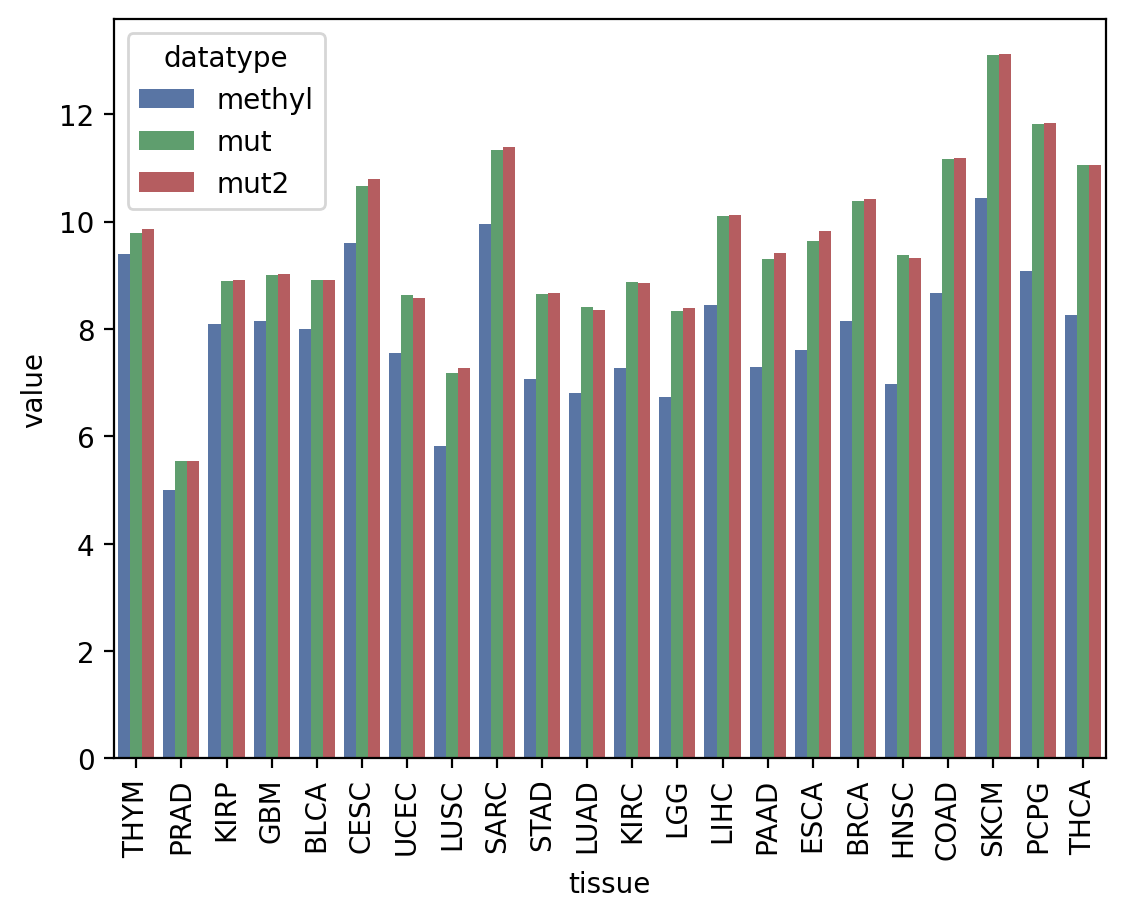

In [141]:
# get the tissues with smallest difference ebtween datatype
mae_diffs = perf_df.query("metric == 'mae'").groupby('tissue').apply(
    lambda x: mean_absolute_error(x.query("datatype == 'methyl'")['value'], x.query("datatype == 'mut'")['value'])
).sort_values(ascending = True).index

sns.barplot(data = perf_df.query("metric == 'mae'"), x = 'tissue', y = 'value', hue = 'datatype', order = mae_diffs)
# angle x labels
_ = plt.xticks(rotation=90)

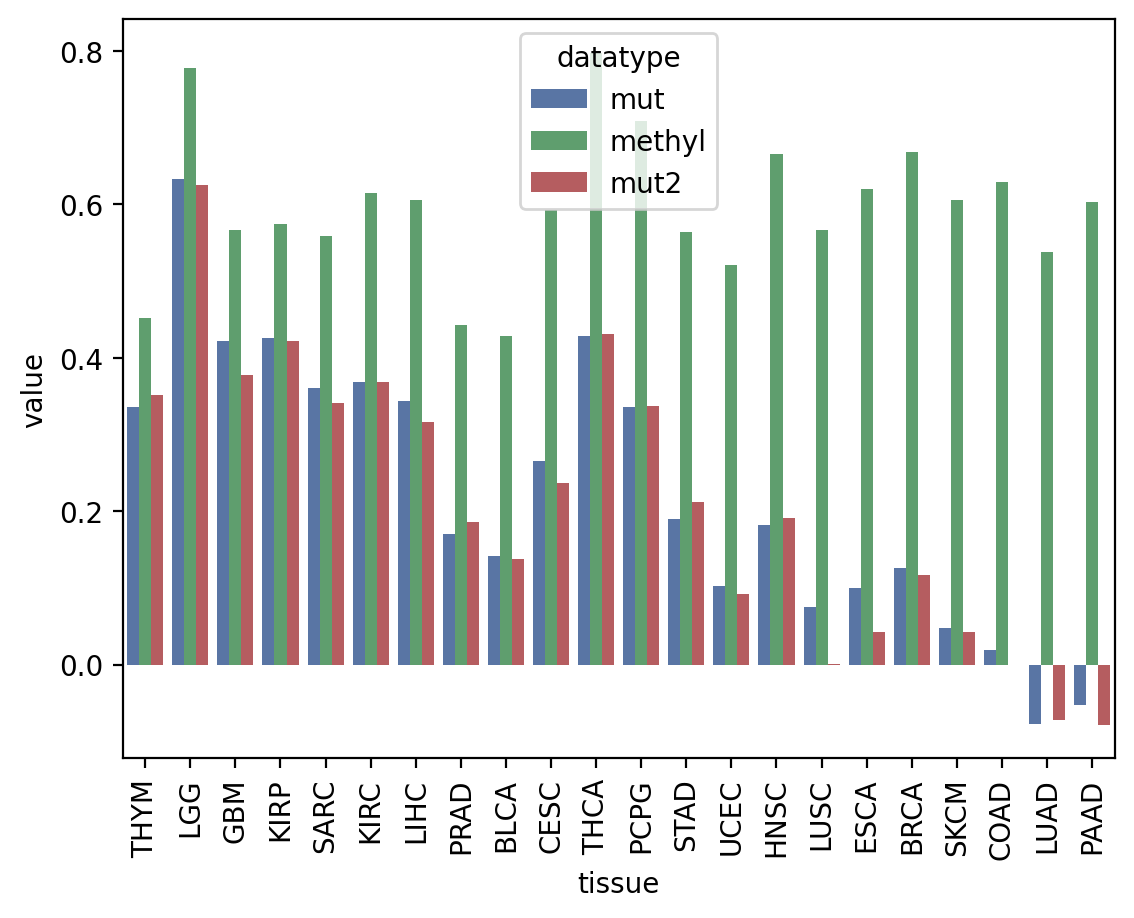

In [142]:
# stricter 2SD outliers 
# get the tissues with smallest difference ebtween datatype
r_diffs = perf_df.query("metric == 'r'").groupby('tissue').apply(
    lambda x: mean_absolute_error(x.query("datatype == 'methyl'")['value'], x.query("datatype == 'mut'")['value'])
).sort_values(ascending = True).index

sns.barplot(data = perf_df.query("metric == 'r'"), x = 'tissue', y = 'value', hue = 'datatype', order = r_diffs)
_ = plt.xticks(rotation=90)


In [148]:
chosen_tissues = list(set(r_diffs[:5]) | set(mae_diffs[:5]))

In [78]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and is_outlier == False and cv_number ==0").groupby(
    'tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers']].corr().reset_index().rename(columns = {'#id': 'id'}).query("id == 'age_at_index'")[['tissue', 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers']].sort_values('mutation_clock_all_feats_wg_logwg_allTissues_noOutliers', ascending=False)

#id,tissue,mutation_clock_all_feats_wg_logwg_allTissues_noOutliers
18,LGG,0.601951
38,THCA,0.532727
10,GBM,0.473761
20,LIHC,0.442226
28,PCPG,0.416805
14,KIRC,0.370170
16,KIRP,0.353383
30,PRAD,0.334792
4,CESC,0.283295
32,SARC,0.256961


In [74]:
mut_clock_cpg_binary.mut_count_w_pred_results_df = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("is_outlier == False")

In [75]:
mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_allTissues_noOutliers',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = 0,
        tissue_subset = []
        )


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done with CV 0


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @top7")[
    ['age_at_index', 'mutation_clock_all_feats_wg_logwg_allTissues']
    ].corr(method = 'pearson')

#id,age_at_index,mutation_clock_all_feats_wg_logwg_allTissues
#id,,
age_at_index,1.00000,0.66012
mutation_clock_all_feats_wg_logwg_allTissues,0.66012,1.00000


In [25]:
top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @top7").groupby('tissue')[
    ['age_at_index', 'mutation_clock_all_feats_wg_logwg_allTissues']
    ].corr(method = 'pearson').sort_values('mutation_clock_all_feats_wg_logwg_allTissues', ascending=False)

,#id,age_at_index,mutation_clock_all_feats_wg_logwg_allTissues
tissue,#id,,
KIRC,mutation_clock_all_feats_wg_logwg_allTissues,0.368285,1.000000
KIRP,mutation_clock_all_feats_wg_logwg_allTissues,0.426786,1.000000
LGG,mutation_clock_all_feats_wg_logwg_allTissues,0.632596,1.000000
PCPG,mutation_clock_all_feats_wg_logwg_allTissues,0.369102,1.000000
PRAD,mutation_clock_all_feats_wg_logwg_allTissues,0.187186,1.000000
SARC,mutation_clock_all_feats_wg_logwg_allTissues,0.370081,1.000000
THCA,mutation_clock_all_feats_wg_logwg_allTissues,0.471663,1.000000
LGG,age_at_index,1.000000,0.632596
THCA,age_at_index,1.000000,0.471663


In [23]:
top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @top7")[
    ['age_at_index', 'mutation_clock_all_feats_wg_logwg_top7']
    ].corr(method = 'pearson')

#id,age_at_index,mutation_clock_all_feats_wg_logwg_top7
#id,,
age_at_index,1.000000,0.664196
mutation_clock_all_feats_wg_logwg_top7,0.664196,1.000000


In [26]:
top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @top7").groupby('tissue')[
    ['age_at_index', 'mutation_clock_all_feats_wg_logwg_top7']
    ].corr(method = 'pearson').sort_values('mutation_clock_all_feats_wg_logwg_top7', ascending=False)

,#id,age_at_index,mutation_clock_all_feats_wg_logwg_top7
tissue,#id,,
KIRC,mutation_clock_all_feats_wg_logwg_top7,0.441797,1.000000
KIRP,mutation_clock_all_feats_wg_logwg_top7,0.411665,1.000000
LGG,mutation_clock_all_feats_wg_logwg_top7,0.623931,1.000000
PCPG,mutation_clock_all_feats_wg_logwg_top7,0.379118,1.000000
PRAD,mutation_clock_all_feats_wg_logwg_top7,0.133475,1.000000
SARC,mutation_clock_all_feats_wg_logwg_top7,0.397992,1.000000
THCA,mutation_clock_all_feats_wg_logwg_top7,0.491697,1.000000
LGG,age_at_index,1.000000,0.623931
THCA,age_at_index,1.000000,0.491697


In [28]:
for t in top7:
    print(t)
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True  and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}'])

LGG
0.6288199357114591
THCA
0.45488894202511926
PCPG
0.2899618428009417
KIRP
0.3552102689545579
SARC
0.32822803696597563
KIRC
0.33277192605312367
PRAD
0.16438148127474453


##### Using MI

In [134]:
all_mis = {}
for i in range(len(top7)):
        this_mi = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/mutual_info_by_tissue/{top7[i]}.parquet")
        all_mis[top7[i]] = this_mi
# combine into df making keys row names 
all_mi_df = pd.concat(all_mis, axis = 1)
# ssitch to single column index
all_mi_df.columns = all_mi_df.columns.map('_'.join)
all_mi_df['mean'] = all_mi_df.mean(axis = 1)
all_mi_df['median'] = all_mi_df.median(axis = 1)

# select top 1000 cpgs for each column
top_cpgs = []
for col in all_mi_df.columns:
        top_cpgs.extend(all_mi_df[col].sort_values(ascending = False).index[:10000].tolist())
top_mi_cpgs = list(set(top_cpgs))

In [ ]:
model = mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_allTissues_topMIAcrossTissues',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = top_mi_cpgs, model_out_dir = "", use_enet = False, just_this_cv_num = 0,
        tissue_subset = [], drop_outliers = False
        )

In [ ]:
for i in range(len(top7)):
        this_mi = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_allTissues_Qnorm_20kbWindow_CpGMuts_binarized/mutual_info_by_tissue/{top7[i]}.parquet")
        this_mi = this_mi.sort_values('mi', ascending=False)
        specific_features = this_mi.head(1000).index.to_list()
        model = mut_clock_cpg_binary.mutational_age_prediction(
                target = 'age_at_index', output_col_label = f'mutation_clock_all_feats_wg_logwg_{top7[i]}_1000mi',
                include_tissue_covariate = False, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
                just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = specific_features, model_out_dir = "", use_enet = False, just_this_cv_num = 0,
                tissue_subset = [top7[i]]
        )
        break

In [80]:
top7 = ['LGG', 'THCA', 'PCPG', 'KIRP', 'SARC', 'KIRC', 'PRAD']
model = mut_clock_cpg_binary.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_top7_newcv0',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = 0,
        tissue_subset = top7
        )

Done with CV 0


In [137]:
# mae of age_at_index and mutation_clock_all_feats_wg_logwg_top7_newcv0
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @top7").groupby(
    'tissue').apply(
        lambda x: mean_absolute_error(x['age_at_index'], x['mutation_clock_all_feats_wg_logwg_allTissues_topMIAcrossTissues']))

tissue
KIRC     8.997268
KIRP     8.617118
LGG      8.585818
PCPG    11.103199
PRAD     5.048018
SARC    12.513187
THCA    10.634037
dtype: float64

In [90]:
# mae of age_at_index and mutation_clock_all_feats_wg_logwg_top7_newcv0
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @top7").groupby(
    'tissue').apply(lambda x: mean_absolute_error(x['age_at_index'], x['mutation_clock_all_feats_wg_logwg_top7_newcv0']))

tissue
KIRC     8.578843
KIRP     8.489096
LGG      8.421198
PCPG    10.975514
PRAD     5.411866
SARC    12.574732
THCA    10.409630
dtype: float64

In [79]:
# .64, .77
for t in top7:
    print(t)
    print("No MI Test")
    print(mean_absolute_error(
        mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")['age_at_index'], mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[f'mutation_clock_all_feats_wg_logwg_{t}']))
    print("No MI Train")
    print(mean_absolute_error(
        mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")['age_at_index'], mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[f'mutation_clock_all_feats_wg_logwg_{t}']))
    print("Top 1000 MI Test")
    print(mean_absolute_error(
        mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")['age_at_index'], mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']))
    print("Top 1000 MI Train")
    print(mean_absolute_error(
        mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")['age_at_index'], mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']))
    break

LGG
No MI Test
7.926064193248749
No MI Train
4.08949467735569
Top 1000 MI Test
7.967408259709676
Top 1000 MI Train
7.6517448610923005


In [78]:
# .64, .77
for t in top7:
    print(t)
    print("No MI Test")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}'])
    print("No MI Train")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}'])
    print("Top 1000 MI Test")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi'])
    print("Top 1000 MI Train")
    # calc MAE
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']
        ]
    break

LGG
No MI Test
0.6544980865715881
No MI Train
0.939374889935406
Top 1000 MI Test
0.6440865353631489
Top 1000 MI Train
0.710100153453634


In [54]:
for t in top7:
    print(t)
    print("No MI Test")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}'])
    print("No MI Train")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}'])
    print("Top 1000 MI Test")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi'])
    print("Top 1000 MI Train")
    print(mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == False and cv_number == 0 and tissue == @t")[
        ['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi']
        ].corr(method = 'pearson').loc['age_at_index', f'mutation_clock_all_feats_wg_logwg_{t}_1000mi'])
    break
    
    

LGG
No MI Test
0.6544980865715881
No MI Train
0.939374889935406
Top 1000 MI Test
0.6477072734222407
Top 1000 MI Train
0.9350544063835846


###### I have learned that selecting by MI speeds up but does not help, dropping outliers does not help, 

# 5a: SoMage scatterplots

In [ ]:
# generated by calling mutationBurdenClock.mutational_age_prediction

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'age_at_index':'Chronological age (years)'}, inplace = True
    )

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'soMage_all_feats_wg', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'soMage_all_feats_wg', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)

sns.lmplot(
    data = to_plot.query("Tissue in ['All']"), x = 'Chronological age (years)', y = 'soMage_all_feats_wg', 
     scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color':my_palette[0]}, line_kws={'color':'black'}
    )

# get pearson corr within each tissue
pearson_corrs = to_plot.query("Tissue in ['All']").groupby('Tissue').apply(lambda x: pearsonr(x['Chronological age (years)'], x['soMage_all_feats_wg'])[0])
mae_by_tissue = to_plot.query("Tissue in ['All']").groupby('Tissue').apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['soMage_all_feats_wg']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Chronological age (years)':'age_at_index'}, inplace = True)

plt.savefig(f"{fig_out_dir}/soMage_perf_scatterplot.svg", dpi = 300, format = 'svg')

In [ ]:
# BRCA LIHC

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'soMage_all_feats_wg':'Mutation Age', 'age_at_index':'Chronological age (years)'}, inplace = True
    )
#tissue_name_map = {'BRCA':'Breast', 'LIHC':'Liver', 'LGG':'Brain', 'COAD':'Colon', 'CESC':'Cervix', 'THCA':'Thyroid', 'UCEC':'Uterus'}
#mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['Tissue'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['Tissue'].map(tissue_name_map)

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Mutation Age', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Mutation Age', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)

hue_order = ['All', 'Brain', 'Colon', 'Liver', 'Cervix', 'Thyroid', 'Uterus', 'Breast']
my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']

# sort to_plot by hue_order
to_plot['Tissue'] = pd.Categorical(to_plot['Tissue'], hue_order[1:])

sns.lmplot(
    data = to_plot.query("Tissue not in ['All']"), x = 'Chronological age (years)', y = 'Mutation Age', hue = 'Tissue', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True} , col = 'Tissue', col_wrap = 4, palette=my_palette[1:], hue_order = hue_order[1:], line_kws={'color':'black'}
    )

# get pearson corr within each tissue
pearson_corrs = to_plot.query("Tissue not in ['All']").groupby('Tissue').apply(lambda x: pearsonr(x['Chronological age (years)'], x['Mutation Age'])[0])
mae_by_tissue = to_plot.query("Tissue not in ['All']").groupby('Tissue').apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['Mutation Age']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Mutation Age': 'soMage_all_feats_wg', 'Chronological age (years)':'age_at_index'}, inplace = True)


plt.savefig(f"{fig_out_dir}/supplemental_soMage_perf_scatterplots_by_tissue.svg", dpi = 300, format = 'svg')


In [ ]:
pearsonr(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )['pred_age'], 
        mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )['soMage_all_feats_wg'] 
)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['pred_age', 'soMage_all_feats_wg', 'age_at_index']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['pred_age', 'soMage_all_feats_wg', 'age_at_index']].corr( method = 'spearman')

### new version of mutation clock

##### Mean vaf + burden

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


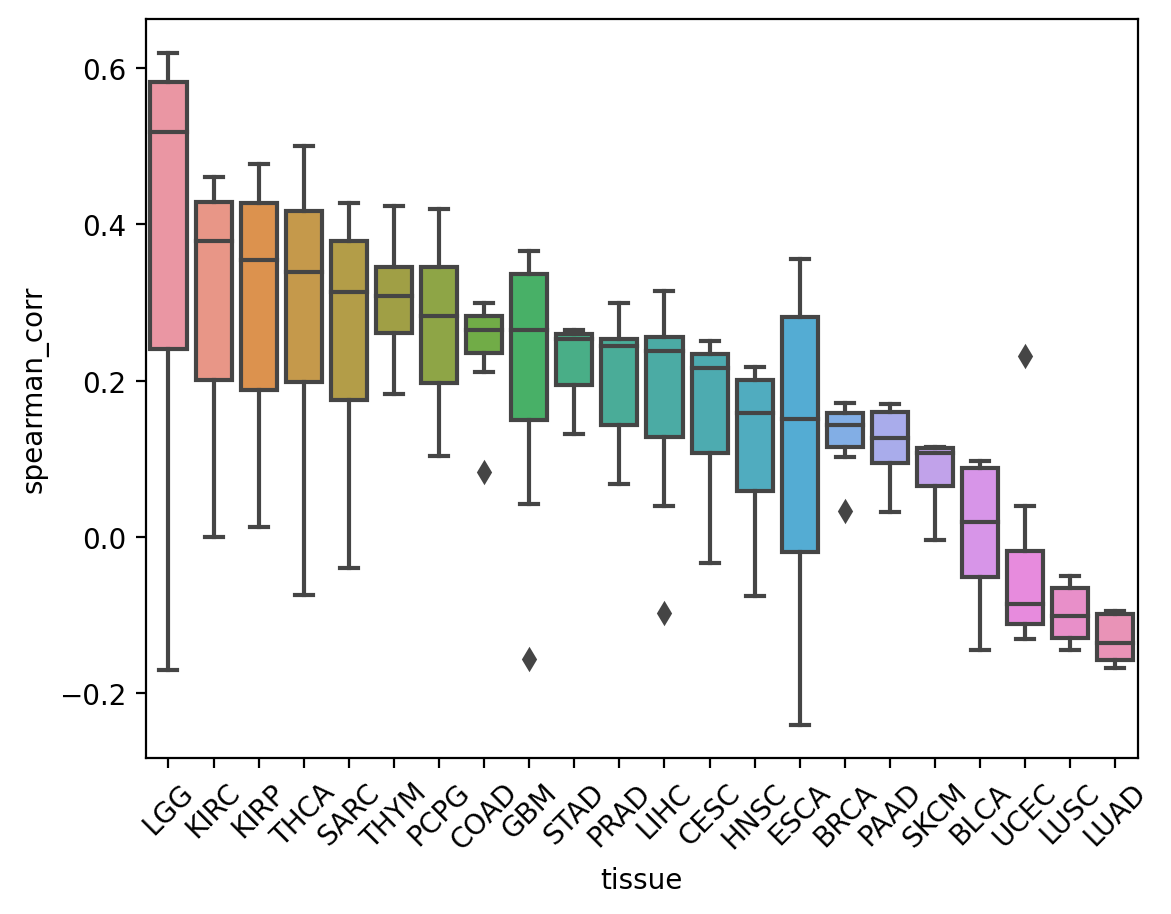

In [7]:
# correlation of mutations and age across all samples
mut_corr_by_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.groupby('tissue')[['age_at_index', 'wg_burden', 'ct_burden', 'ctga_burden', 'wg_vaf_sum', 'wg_vaf_mean', 'wg_vaf_std', 'mut_sum']].corr(method = 'spearman')
mut_corr_by_tissue.reset_index(inplace = True)
# make long matrix for plotting
mut_corr_by_tissue = mut_corr_by_tissue.query("level_1 == 'age_at_index'").melt(id_vars = ['tissue'], value_vars = ['wg_burden', 'ct_burden', 'ctga_burden', 'wg_vaf_sum', 'wg_vaf_mean', 'wg_vaf_std', 'mut_sum'])
mut_corr_by_tissue.columns = ['tissue', 'mutation_count_method', 'spearman_corr']
order = mut_corr_by_tissue.groupby('tissue').median().sort_values('spearman_corr', ascending = False).index
sns.boxplot(data = mut_corr_by_tissue, x = 'tissue', y = 'spearman_corr', order = order)
_ = plt.xticks(rotation = 45)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


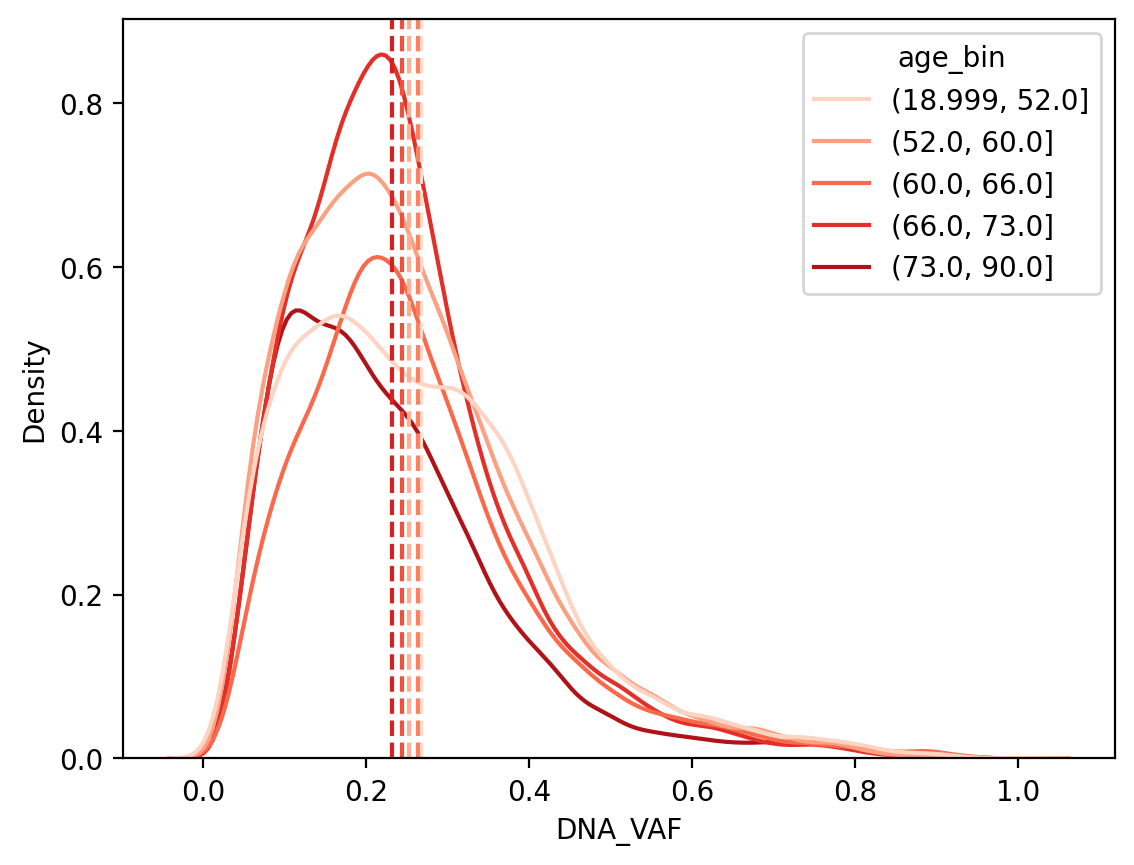

In [46]:
tissue = 'HNSC'
this_tissue_muts = all_mut_w_age_df.query("dataset == @tissue")
this_tissue_muts['age_bin'] = pd.qcut(this_tissue_muts['age_at_index'], q = 5, duplicates = 'drop')
# get mean value of each age_bin
means = this_tissue_muts.groupby('age_bin')['DNA_VAF'].mean().reset_index()
sns.kdeplot(data = this_tissue_muts, x = 'DNA_VAF', hue = 'age_bin', palette='Reds')
# add mean line, with color of age_bin
for i, row in means.iterrows():
    plt.axvline(row['DNA_VAF'], color = sns.color_palette('Reds')[i], linestyle = '--')

In [10]:
mean_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].mean()
median_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].median()
std_vaf_by_samples = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].std()
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['mean_vaf'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(mean_vaf_by_samples)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['median_vaf'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(median_vaf_by_samples)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['std_vaf'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(std_vaf_by_samples)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['std_vaf'].fillna(0, inplace = True)

In [11]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("is_outlier == False")

In [12]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_mixed_linear_model(
    formula = "age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue", re_formula = "",
    tissue = 'all', pred_name = "age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue",
    )

The Hessian matrix at the estimated parameter values is not positive definite.


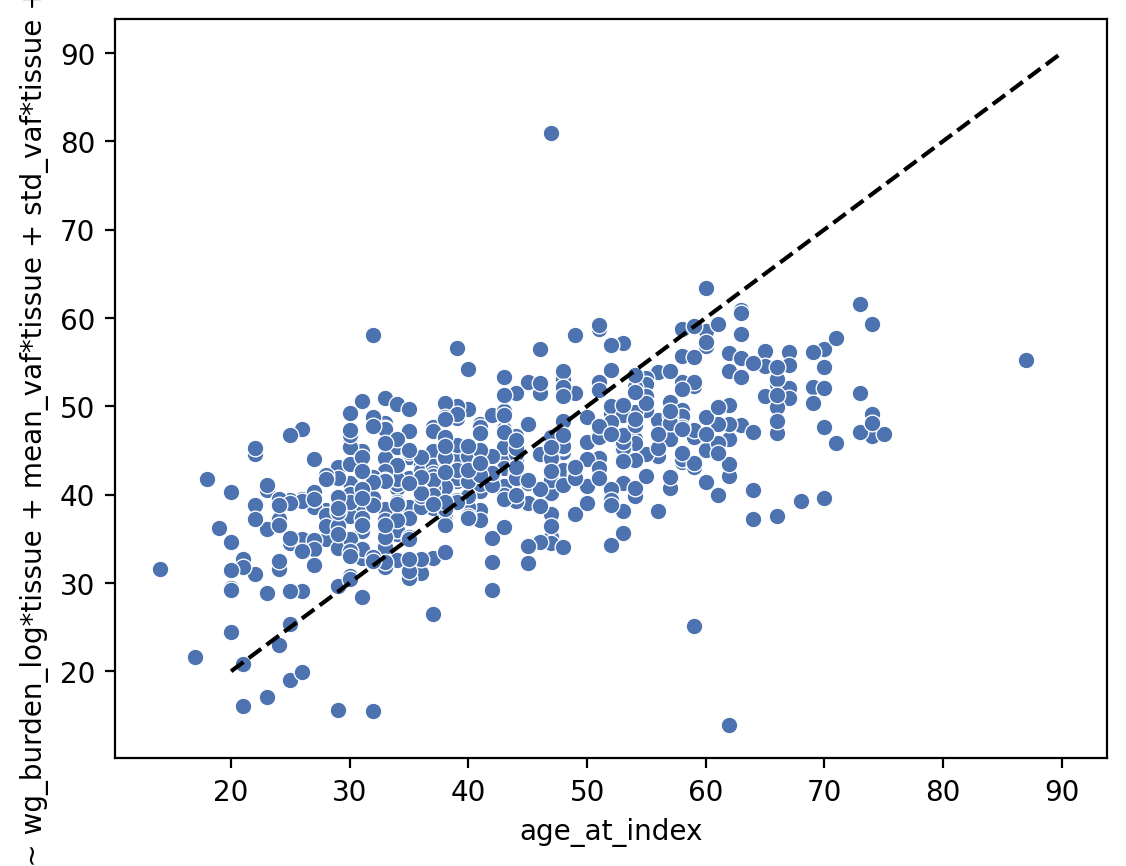

In [23]:
sns.scatterplot(
    data = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("tissue == 'LGG'"),
    y = "age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue",
    x = 'age_at_index'
    )
# plot y = x
plt.plot([20, 90], [20, 90], linestyle = '--', color = 'black')

In [13]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.groupby('tissue')[
    ['age_at_index', "age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue"]
    ].corr(method = 'spearman').reset_index().query("level_1 == 'age_at_index'").sort_values('age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue', ascending = False)

,tissue,level_1,age_at_index,age_at_index ~ wg_burden_log*tissue + mean_vaf*tissue + std_vaf*tissue + median_vaf*tissue
18,LGG,age_at_index,1.0,0.625639
16,KIRP,age_at_index,1.0,0.504882
38,THCA,age_at_index,1.0,0.495434
14,KIRC,age_at_index,1.0,0.476125
10,GBM,age_at_index,1.0,0.446060
28,PCPG,age_at_index,1.0,0.432315
40,THYM,age_at_index,1.0,0.421936
32,SARC,age_at_index,1.0,0.384830
8,ESCA,age_at_index,1.0,0.360894
30,PRAD,age_at_index,1.0,0.308214


In [53]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgbCV_summstats',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = order[:-4]
        )

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=50; total time= 2.6min
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=50; total time= 2.7min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=250; total time=12.1min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=250; total time=12.5min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=450; total time=21.5min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=450; total time=22.3min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=650; total time=30.9min
[CV] END ..max_depth=2, min_child_weight=1, n_estimators=650; total time=32.0min
[CV] END ...max_depth=2, min_child_weight=3, n_estimators=50; total time= 2.6min
[CV] END ...max_depth=2, min_child_weight=3, n_estimators=50; total time= 2.7min
[CV] END ..max_depth=2, min_child_weight=3, n_estimators=250; total time=12.0min
[CV] END ..max_depth=2, min_child_weight=3, n_es

In [52]:
t =  order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and tissue in @t"
    ).groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgbCV_summstats']].corr().reset_index().query("level_1 == 'age_at_index'").sort_values('mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgbCV_summstats', ascending = False)

,tissue,level_1,age_at_index,mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgbCV_summstats
16,LGG,age_at_index,1.0,0.532560
32,THCA,age_at_index,1.0,0.460951
12,KIRC,age_at_index,1.0,0.459516
14,KIRP,age_at_index,1.0,0.453537
34,THYM,age_at_index,1.0,0.383484
22,PCPG,age_at_index,1.0,0.351983
26,SARC,age_at_index,1.0,0.340559
8,GBM,age_at_index,1.0,0.328155
30,STAD,age_at_index,1.0,0.294290
18,LIHC,age_at_index,1.0,0.291760


In [45]:
t =  order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and tissue in @t"
    ).groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet_summstats']].corr().reset_index().query("level_1 == 'age_at_index'").sort_values('mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet_summstats', ascending = False)

,tissue,level_1,age_at_index,mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet_summstats
16,LGG,age_at_index,1.0,0.532489
32,THCA,age_at_index,1.0,0.460505
12,KIRC,age_at_index,1.0,0.459574
14,KIRP,age_at_index,1.0,0.453741
34,THYM,age_at_index,1.0,0.383592
22,PCPG,age_at_index,1.0,0.351887
26,SARC,age_at_index,1.0,0.340563
8,GBM,age_at_index,1.0,0.328069
30,STAD,age_at_index,1.0,0.294280
18,LIHC,age_at_index,1.0,0.291757


In [40]:
t =  order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and tissue in @t"
    ).groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgb_summstats']].corr().reset_index().query("level_1 == 'age_at_index'").sort_values('mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgb_summstats', ascending = False)

,tissue,level_1,age_at_index,mutation_clock_all_feats_wg_logwg_tissue_all_minus4_xgb_summstats
16,LGG,age_at_index,1.0,0.632078
32,THCA,age_at_index,1.0,0.445993
14,KIRP,age_at_index,1.0,0.405023
12,KIRC,age_at_index,1.0,0.404463
22,PCPG,age_at_index,1.0,0.387744
34,THYM,age_at_index,1.0,0.385156
26,SARC,age_at_index,1.0,0.360139
8,GBM,age_at_index,1.0,0.354998
18,LIHC,age_at_index,1.0,0.247570
10,HNSC,age_at_index,1.0,0.206878


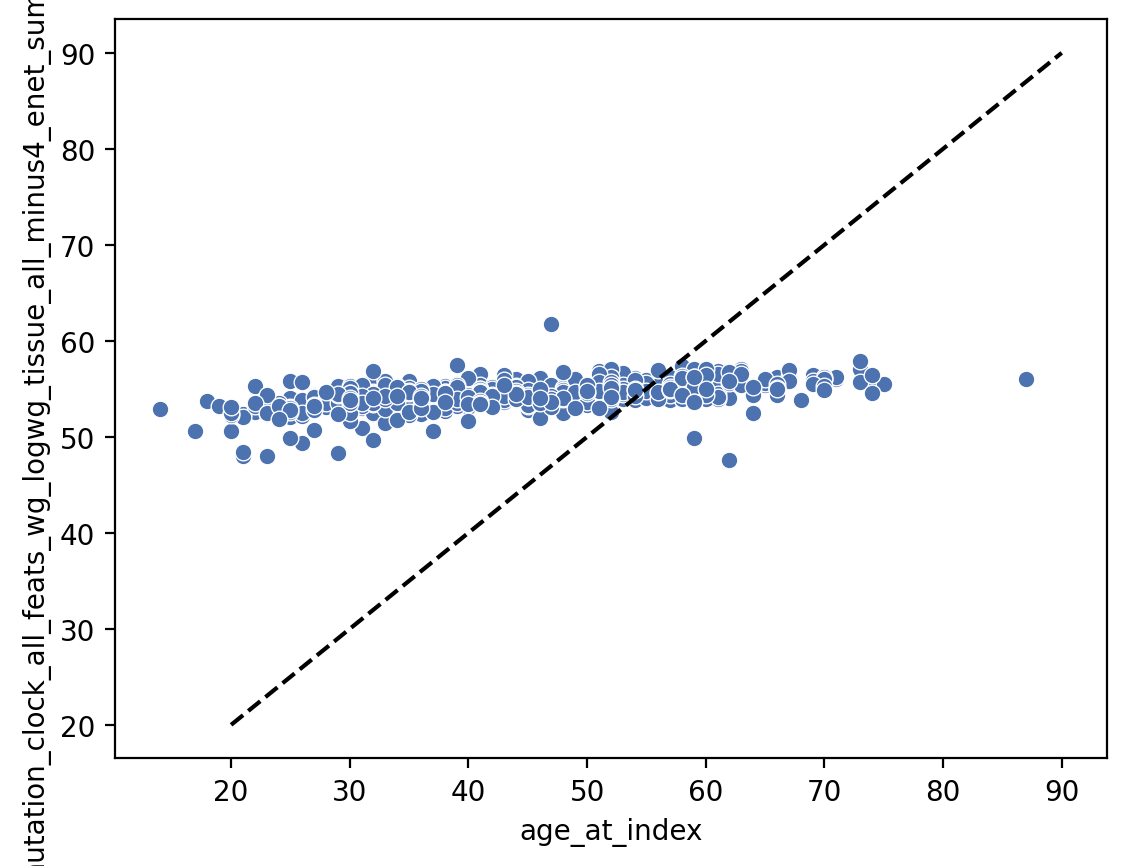

In [48]:
sns.scatterplot(
    data = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("tissue == 'LGG' and this_cv_test_sample == True "),
    y = "mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet_summstats",
    x = 'age_at_index'
    )
# plot y = x
plt.plot([20, 90], [20, 90], linestyle = '--', color = 'black')

##### vaf bins

In [50]:
all_mut_w_age_df['VAF_bin'] = pd.cut(all_mut_w_age_df['DNA_VAF'], bins = np.linspace(0,1,11))
vaf_mut_counts = all_mut_w_age_df.groupby(['case_submitter_id', 'VAF_bin'])['DNA_VAF'].count().reset_index()
vaf_mut_counts['age_at_index'] = vaf_mut_counts['case_submitter_id'].map(all_methyl_age_df_t['age_at_index'])
vaf_mut_counts['tissue'] = vaf_mut_counts['case_submitter_id'].map(all_methyl_age_df_t['dataset'])

In [40]:
vaf_mut_counts[['age_at_index', 'DNA_VAF']].corr(method = 'spearman')

,age_at_index,DNA_VAF
age_at_index,1.000000,0.137934
DNA_VAF,0.137934,1.000000


In [59]:
vaf_mut_counts_tp = vaf_mut_counts.groupby(['VAF_bin', 'tissue'])[['age_at_index', 'DNA_VAF']].corr(method = 'spearman').reset_index().query("level_2 == 'age_at_index'")

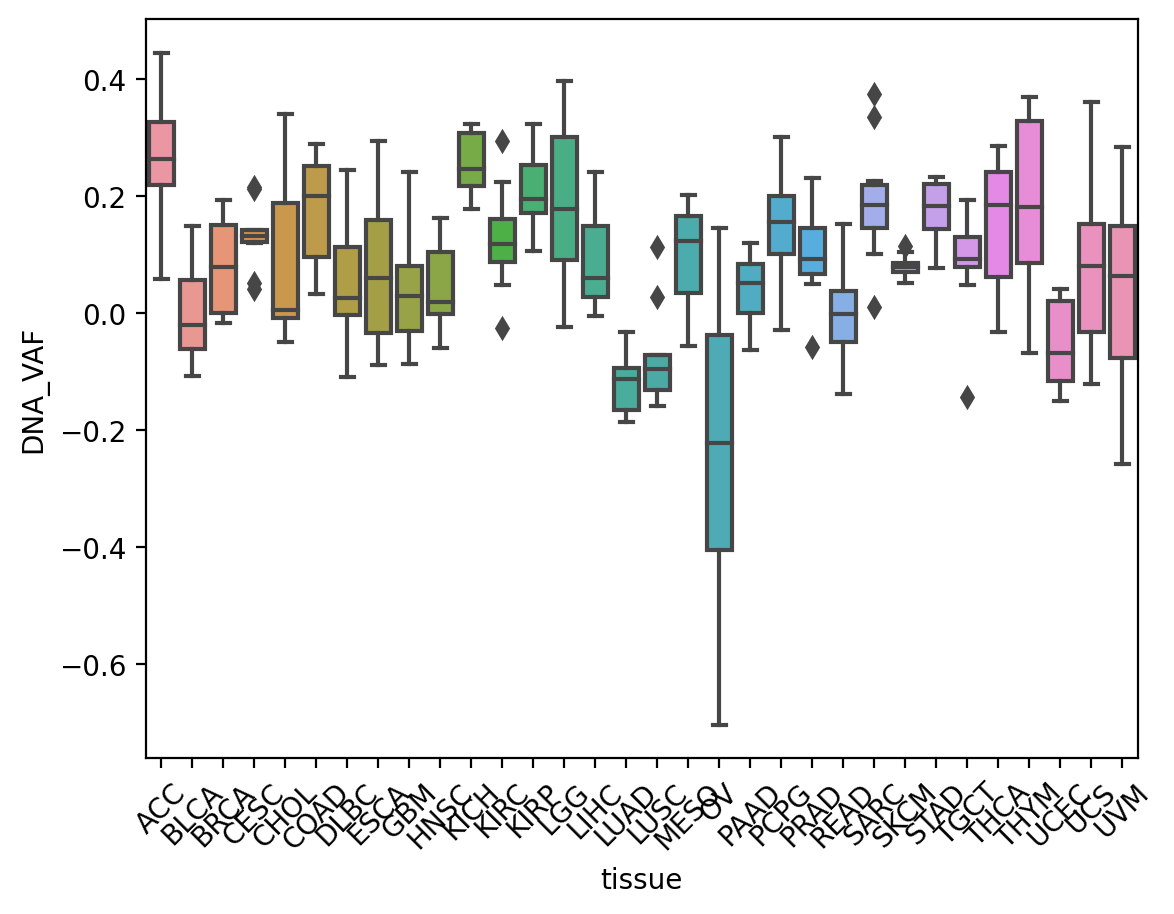

In [64]:
sns.boxplot(data = vaf_mut_counts_tp, x = 'tissue', y = 'DNA_VAF')
# angle x ticks
_ = plt.xticks(rotation = 45)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.groupby('DNA_VAF')[['wg_burden', 'age_at_index']].corr(method = 'spearman')

In [89]:
wg_burden_limited_vaf = all_mut_w_age_df.query("DNA_VAF > 0 and DNA_VAF < 1").groupby('case_submitter_id')['DNA_VAF'].count().reset_index()
wg_burden_limited_vaf['age_at_index'] = wg_burden_limited_vaf['case_submitter_id'].map(all_methyl_age_df_t['age_at_index'])
wg_burden_limited_vaf['tissue'] = wg_burden_limited_vaf['case_submitter_id'].map(all_methyl_age_df_t['dataset'])

In [90]:
wg_burden_limited_vaf.groupby('tissue')[['age_at_index', 'DNA_VAF']].corr(method = 'spearman').reset_index().query("level_1 == 'age_at_index'").sort_values('DNA_VAF', ascending = False)['DNA_VAF'].describe()

count    32.000000
mean      0.241564
std       0.192281
min      -0.165657
25%       0.144343
50%       0.243055
75%       0.397393
max       0.595273
Name: DNA_VAF, dtype: float64

In [88]:
wg_burden_limited_vaf.groupby('tissue')[['age_at_index', 'DNA_VAF']].corr(method = 'spearman').reset_index().query("level_1 == 'age_at_index'").sort_values('DNA_VAF', ascending = False)['DNA_VAF'].describe()

count    32.000000
mean      0.243311
std       0.166371
min      -0.129327
25%       0.163570
50%       0.247538
75%       0.358871
max       0.619752
Name: DNA_VAF, dtype: float64

### Fix massive fumble of the bag

In [ ]:
wg_burden = all_mut_w_age_df['case_submitter_id'].value_counts()
wg_vaf_sum = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].sum()
wg_vaf_mean = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].mean()
wg_vaf_std = all_mut_w_age_df.groupby('case_submitter_id')['DNA_VAF'].std()
ct_burden = all_mut_w_age_df.query("mutation == 'C>T'")['case_submitter_id'].value_counts()
ctga_burden = all_mut_w_age_df.query("mutation == 'C>T' or mutation == 'G>A'")['case_submitter_id'].value_counts()
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_burden'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(wg_burden)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ct_burden'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(ct_burden)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ctga_burden'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(ctga_burden)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_sum'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(wg_vaf_sum)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_mean'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(wg_vaf_mean)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_std'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.map(wg_vaf_std)
# log scale each
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_burden_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_burden']+1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ct_burden_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ct_burden']+1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ctga_burden_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['ctga_burden']+1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_sum_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_sum']+1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_mean_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_mean']+1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_std_log'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_vaf_std']+1)
# do burden sum
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['mut_sum'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df[mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns[:100000]].sum(axis = 1)
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['log_mut_sum'] = np.log(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['wg_burden']+1)

In [ ]:
# correlation of mutations and age across all samples
mut_corr_by_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.groupby('tissue')[['age_at_index', 'wg_burden', 'ct_burden', 'ctga_burden', 'wg_vaf_sum', 'wg_vaf_mean', 'wg_vaf_std', 'mut_sum']].corr(method = 'spearman')
mut_corr_by_tissue.reset_index(inplace = True)
# make long matrix for plotting
mut_corr_by_tissue = mut_corr_by_tissue.query("level_1 == 'age_at_index'").melt(id_vars = ['tissue'], value_vars = ['wg_burden', 'ct_burden', 'ctga_burden', 'wg_vaf_sum', 'wg_vaf_mean', 'wg_vaf_std', 'mut_sum'])
mut_corr_by_tissue.columns = ['tissue', 'mutation_count_method', 'spearman_corr']

In [ ]:
order = mut_corr_by_tissue.groupby('tissue').median().sort_values('spearman_corr', ascending = False).index
sns.boxplot(data = mut_corr_by_tissue, x = 'tissue', y = 'spearman_corr', order = order)
_ = plt.xticks(rotation = 45)


In [ ]:
tp = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and tissue in ['BRCA']"
    )

sns.scatterplot(data = tp, x = 'age_at_index', y = 'wg_burden')
plt.ylim(0,200)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(
        pred_age_name =  "mutation_clock_all_feats_wg_logwg_tissue_all_minus4", 
        tissues = order[:-4], 
        out_fn = ""
        )

In [ ]:
ts = ['LGG', 'KIRC', 'THCA', 'SARC', 'THYM', 'PCPG', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts")[['age_at_index', 'methyl_clock_xgb_pred']].corr(method = 'spearman')

In [ ]:
ts = ['LGG', 'KIRC', 'THCA', 'SARC', 'THYM', 'PCPG', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts").groupby('tissue')[['age_at_index', 'methyl_clock_xgb_pred']].corr(method = 'spearman')

In [ ]:
order[:-4]

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = True, just_this_cv_num = -1,
        tissue_subset = order[:-4]
        )

In [ ]:
t = order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and cv_number == 0 and tissue in @t"
    ).groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet','mutation_clock_all_feats_wg_logwg_tissue_all_minus4', 'methyl_clock_xgb_pred']].corr().reset_index().query("level_1 == 'age_at_index'").sort_values('mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet', ascending = False)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and cv_number == 0 and tissue in @order[:-4]"
    )
#[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_enet', 'methyl_clock_xgb_pred']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in ['LGG','GMB','THYM','THCA','CESC']")[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4', 'methyl_clock_xgb_pred']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['methyl_clock_resid'] =  mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['methyl_clock_xgb_pred'] - mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_at_index']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['mutation_clock_all_feats_wg_logwg_tissue_all_minus4_resid'] =  mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['mutation_clock_all_feats_wg_logwg_tissue_all_minus4'] - mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_at_index']

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in ['LGG','GMB','THYM','THCA','CESC']")[['age_at_index', 'methyl_clock_resid', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4_resid']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in ['LGG','GMB','THYM','THCA','CESC']")[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4']].corr(method = 'pearson')

In [ ]:
ts = order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts").groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4']].corr(method = 'pearson').reset_index().query("level_1 == 'age_at_index'").sort_values(by = 'mutation_clock_all_feats_wg_logwg_tissue_all_minus4', ascending = False)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_all_minus4',
        include_tissue_covariate = False, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = order[:-4]
        )

In [ ]:
ts = order[:-4]
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts").groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_all_minus4']].corr(method = 'pearson').reset_index().query("level_1 == 'age_at_index'").sort_values(by = 'mutation_clock_all_feats_wg_logwg_all_minus4', ascending = False)

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_logwg_tissue_LGG_KIRC_THCA_SARC_THYM_PCPG_STAD',
        include_tissue_covariate = True, include_wg_burden_covariate = True, include_log_wg_burden_covariate = True, 
        just_clock_cpgs = False, log_scale_feats = False, log_scale_labels = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1,
        tissue_subset = ['LGG', 'KIRC', 'THCA', 'SARC', 'THYM', 'PCPG', 'STAD']
        )

In [ ]:
ts = ['LGG', 'KIRC', 'THCA', 'SARC', 'THYM', 'PCPG', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts")[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_LGG_KIRC_THCA_SARC_THYM_PCPG_STAD']].corr(method = 'spearman')

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df

In [ ]:
ts = ['LGG', 'KIRC', 'THCA', 'SARC', 'THYM', 'PCPG', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts").groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_LGG_KIRC_THCA_SARC_THYM_PCPG_STAD']].corr(method = 'pearson')

In [ ]:
ts = ['LGG', 'KIRC', 'KIRP', 'THCA', 'SARC', 'THYM', 'PCPG','GBM', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts")[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_LGG_KIRC_KIRP_THCA_SARC_THYM_PCPG_GBM_STAD']].corr(method = 'spearman')

In [ ]:
ts = ['LGG', 'KIRC', 'KIRP', 'THCA', 'SARC', 'THYM', 'PCPG','GBM', 'STAD']
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts").groupby('tissue')[['age_at_index', 'mutation_clock_all_feats_wg_logwg_tissue_LGG_KIRC_KIRP_THCA_SARC_THYM_PCPG_GBM_STAD']].corr(method = 'pearson')

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True and cv_number == 0 and tissue in @ts")[['age_at_index', 'methyl_clock_xgb_pred']].corr(method = 'spearman')

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats', include_tissue_covariate = False, include_wg_burden_covariate = False, just_clock_cpgs = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_tissue', include_tissue_covariate = True, include_wg_burden_covariate = False, just_clock_cpgs = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg', include_tissue_covariate = False, include_wg_burden_covariate = True, just_clock_cpgs = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_logwg', include_tissue_covariate = False, include_wg_burden_covariate = False, include_log_wg_burden_covariate = True, just_clock_cpgs = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = 0
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_tissue', include_tissue_covariate = True, include_wg_burden_covariate = True, just_clock_cpgs = False, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_tissue_logfeats', include_tissue_covariate = True, include_wg_burden_covariate = True, just_clock_cpgs = False, 
        log_scale_feats = True, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index', output_col_label = 'mutation_clock_all_feats_wg_tissue_logage', include_tissue_covariate = True, include_wg_burden_covariate = True, just_clock_cpgs = False, 
        log_scale_feats = False, log_scale_labels = True, specific_features = [], model_out_dir = "", use_enet = False, just_this_cv_num = -1
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True").groupby("tissue")[['age_at_index','mutation_clock_all_feats']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True").groupby("tissue")[['age_at_index','mutation_clock_all_feats_wg']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True and cv_number == 0").groupby("tissue")[['age_at_index','mutation_clock_all_feats_logwg']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True").groupby("tissue")[['age_at_index','mutation_clock_all_feats_wg_tissue']].corr(method = 'spearman')

In [ ]:
# log age
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                ).groupby("tissue")[['age_at_index','mutation_clock_all_feats_wg_tissue_logage']].corr()

In [ ]:
# log feats
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True and cv_number == 0"
                ).groupby("tissue")[['age_at_index','mutation_clock_all_feats_wg_tissue_logfeats']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(pred_age_name = 'mutation_clock_all_feats_wg_tissue_logage', out_fn = "")

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(pred_age_name = 'mutation_clock_all_feats_wg', out_fn = "")

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(pred_age_name = 'mutation_clock_all_feats_logwg', out_fn = "")

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(
    pred_age_name = 'mutation_clock_all_feats_tissue', out_fn = ""
    )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.plot_age_prediction_scatterplots(pred_age_name = 'mutation_clock_all_feats_wg_tissue_logfeats', out_fn = "")

In [ ]:
all_mut_w_age_df['dataset'].value_counts() / all_methyl_age_df_t['dataset'].value_counts()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True and cv_number == 4"
                )

In [ ]:
# from running mutationBurdenClock.mutational_age_prediction with enet argument

In [ ]:
test_df0 = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_chosen_cpg_burden_w_pred_5CV_with_mut_enet_CV0.parquet")

In [ ]:
test_df1 = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_chosen_cpg_burden_w_pred_5CV_with_mut_enet_CV1.parquet")

In [ ]:
test_df0['mutation_clock_enet']

In [ ]:
test_df0.query("this_cv_test_sample == True")[['mutation_clock_enet','age_at_index']].corr()

In [ ]:
test_df[['mutation_clock_enet']]

# 5b: Pancan scatterplots

In [ ]:
# generated by calling train_burden_epi_clocks.py

In [ ]:
# passes the cv equiv test, phew
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                ).groupby('cv_number')[['age_at_index', 'pred_age']].corr()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'pred_age':'Methylation Age', 'age_at_index':'Chronological age (years)'}, inplace = True
    )

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Epigenetic age', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Epigenetic age', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)

sns.lmplot(
    data = to_plot.query("Tissue in ['All']"), x = 'Chronological age (years)', y = 'Methylation Age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color':'steelblue'} , line_kws={'color':'steelblue'},
    
    )
# get pearson corr within each tissue
pearson_corrs = to_plot.query("Tissue in ['All']").groupby('Tissue').apply(lambda x: pearsonr(x['Chronological age (years)'], x['Epigenetic age'])[0])
mae_by_tissue = to_plot.query("Tissue in ['All']").groupby('Tissue').apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['Epigenetic age']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
# save to svg
    
# rename back
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Methylation Age':'pred_age', 'Chronological age (years)':'age_at_index'}, inplace = True)

plt.savefig(f"{fig_out_dir}/pancan_clock_scatterplots.svg", dpi = 300, format = 'svg')


In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'pred_age':'Methylation Age', 'age_at_index':'Chronological age (years)'}, inplace = True
    )

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Methylation Age', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Methylation Age', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)

hue_order = ['All', 'Brain', 'Colon', 'Liver', 'Cervix', 'Thyroid', 'Uterus', 'Breast']
my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']

# sort to_plot by hue_order
to_plot['Tissue'] = pd.Categorical(to_plot['Tissue'], hue_order[1:])


sns.lmplot(
    data = to_plot.query("Tissue not in ['All']"), x = 'Chronological age (years)', y = 'Methylation Age', hue = 'Tissue', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True} , col = 'Tissue', col_wrap = 4, palette=my_palette[1:], hue_order = hue_order[1:], line_kws={'color':'black'}
    )
# get pearson corr within each tissue
pearson_corrs = to_plot.query("Tissue not in ['All']").groupby('Tissue').apply(lambda x: pearsonr(x['Chronological age (years)'], x['Methylation Age'])[0])
mae_by_tissue = to_plot.query("Tissue not in ['All']").groupby('Tissue').apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['Methylation Age']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
# save to svg
    
# rename back
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Methylation Age':'pred_age', 'Chronological age (years)':'age_at_index'}, inplace = True)

plt.savefig(f"{fig_out_dir}/supplemental_pancan_clock_scatterplots_by_tissue.svg", dpi = 300, format = 'svg')


### XGB epi clock

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.epi_age_prediction_xgb(
        output_col_label = 'pred_age_xgb',
        include_tissue_covariate = False,
        target = 'age_at_index'
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'pred_age_xgb':'Methylation Age (tree)', 'age_at_index':'Chronological age (years)'}, inplace = True
    )

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Methylation Age (tree)', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Methylation Age (tree)', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)

hue_order = ['All', 'Brain', 'Colon', 'Liver', 'Cervix', 'Thyroid', 'Uterus', 'Breast']
my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']

# sort to_plot by hue_order
to_plot['Tissue'] = pd.Categorical(to_plot['Tissue'], hue_order)



sns.lmplot(
    data = to_plot, x = 'Chronological age (years)', y = 'Methylation Age (tree)', hue = 'Tissue', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True}, 
    col = 'Tissue', col_wrap = 4,
    palette=my_palette, hue_order = hue_order, line_kws={'color':'black'}
    )

# get pearson corr within each tissue
pearson_corrs = to_plot.groupby('Tissue').apply(lambda x: pearsonr(x['Chronological age (years)'], x['Methylation Age (tree)'])[0])
mae_by_tissue = to_plot.groupby('Tissue').apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['Methylation Age (tree)']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
# save to svg
    
# rename back
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Methylation Age (tree)':'pred_age_xgb', 'Chronological age (years)':'age_at_index'}, inplace = True)

plt.savefig(f"{fig_out_dir}/supplemental_XGB_pancan_clock_scatterplots_by_tissue.svg", dpi = 300, format = 'svg')


# TMB 

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(
    columns = {'tissue':'Tissue', 'log_wg_burden':'Whole genome mutation burden', 'age_at_index':'Chronological age (years)'}, inplace = True
    )

all_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Whole genome mutation burden', 'Chronological age (years)']].copy(deep = True)
all_tissue['Tissue'] = 'All'

each_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Whole genome mutation burden', 'Chronological age (years)']].copy(deep = True)
# combine on top of each other
to_plot = pd.concat([all_tissue, each_tissue], axis = 0)


hue_order = ['All', 'Brain', 'Colon', 'Liver', 'Cervix', 'Thyroid', 'Uterus', 'Breast']



sns.lmplot(
    data = to_plot, x = 'Chronological age (years)', y = 'Whole genome mutation burden', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True} , line_kws={'color':'black'},
    hue_order=hue_order, hue = 'Tissue', col = 'Tissue', col_wrap = 4, palette=my_palette, col_order=hue_order
    )
# get pearson corr within each tissue
pearson_corrs = to_plot.apply(lambda x: pearsonr(x['Chronological age (years)'], x['Whole genome mutation burden'])[0])
mae_by_tissue = to_plot.apply(lambda x: mean_absolute_error(x['Chronological age (years)'], x['Whole genome mutation burden']))
# add pearson and mae to each plot
for ax, tissue in zip(plt.gcf().axes, pearson_corrs.index.tolist()):
    ax.annotate(f"Pearson r = {pearson_corrs.loc[tissue]:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
    ax.set_title(tissue)
    ax.annotate(f"MAE = {mae_by_tissue.loc[tissue]:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
# save to svg
    
# rename back
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Whole genome mutation burden':'log_wg_burden', 'Chronological age (years)':'age_at_index'}, inplace = True)

plt.savefig(f"{fig_out_dir}/supp_wgmb_scatterplots.svg", dpi = 300, format = 'svg')


# Combined clock and mutation corrected clock

In [ ]:
age_res = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("age_at_index ~ pred_age + soMage_all_feats_wg", tissue = 'all', pred_name = 'age~pred_age + soMage_all_feats_wg')


mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'tissue':'Tissue', 'age_at_index': 'Chronological age (years)'}, inplace = True)


to_plot= mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'age~pred_age + soMage_all_feats_wg', 'Chronological age (years)']].copy(deep = True)

sns.lmplot(
    data = to_plot.query("Tissue not in ['BRCA', 'LIHC']"), x = 'Chronological age (years)', y = 'age~pred_age + soMage_all_feats_wg', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True} , palette=my_palette[:-2]
    )

# add pearson R and MAE
pearson_r = pearsonr(to_plot['Chronological age (years)'], to_plot['age~pred_age + soMage_all_feats_wg'])[0]
mae = mean_absolute_error(to_plot['Chronological age (years)'], to_plot['age~pred_age + soMage_all_feats_wg'])
plt.annotate(f"Pearson r = {pearson_r:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
plt.annotate(f"MAE = {mae:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Chronological age (years)':'age_at_index'}, inplace = True)


In [ ]:
age_res = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("age_at_index ~ pred_age + soMresidual", tissue = 'all', pred_name = 'age~pred_age + soMresidual')

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['Mutation corrected epi-age'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['pred_age'] + mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['soMresidual']

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'tissue':'Tissue', 'age_at_index': 'Chronological age (years)'}, inplace = True)


to_plot= mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
                "this_cv_test_sample == True"
                )[['Tissue', 'Mutation corrected epi-age', 'Chronological age (years)']].copy(deep = True)

sns.lmplot(
    data = to_plot.query("Tissue not in ['BRCA', 'LIHC']"), x = 'Chronological age (years)', y = 'Mutation corrected epi-age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True} , palette=my_palette[:-2]
    )

# add pearson R and MAE
pearson_r = pearsonr(to_plot.query("Tissue not in ['BRCA', 'LIHC']")['Chronological age (years)'], to_plot.query("Tissue not in ['BRCA', 'LIHC']")['Mutation corrected epi-age'])[0]
mae = mean_absolute_error(to_plot.query("Tissue not in ['BRCA', 'LIHC']")['Chronological age (years)'], to_plot.query("Tissue not in ['BRCA', 'LIHC']")['Mutation corrected epi-age'])
plt.annotate(f"Pearson r = {pearson_r:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
plt.annotate(f"MAE = {mae:.2f} years", xy = (0.05, 0.85), xycoords = 'axes fraction')
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.rename(columns = {'Tissue':'tissue', 'Chronological age (years)':'age_at_index'}, inplace = True)


In [ ]:
mae

# 5C: clock burden groupboxplots

In [ ]:
bin_size = 5
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_bin'] = pd.cut(
    mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            )['age_at_index'],
    bins = [x for x in range(20, 90, bin_size)], labels = [f'{i} - {i+bin_size}' for i in range(20, 90-bin_size, bin_size)]
    )

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['soMage_all_feats_wg_bins'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('age_bin')['soMage_all_feats_wg'].transform(lambda x: pd.cut(x, bins = 3, duplicates = 'drop', labels = ['Low', 'Intermediate', 'High']))


fig, axes = plt.subplots(figsize = (14, 5))
sns.boxplot(
    data = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            ), x='age_bin', hue = 'soMage_all_feats_wg_bins', y = 'pred_age', ax = axes, palette='Reds'
            )
plt.ylabel('Methylation Age')
plt.xlabel('Chronological age (years)')
sns.despine()
# change legend name
_ = axes.legend(title = 'Mutation Age', loc = 'upper left')
# angle x tick labels
#_ = plt.xticks(rotation=25, ha = 'center')
#plt.savefig(f"{fig_out_dir}/pancan_lm_clock_burden_qcut_boxplots.svg", dpi = 300, format = 'svg')

In [ ]:
# get pvals between boxplots
pvals = {}
for age_bin in mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            )['age_bin'].unique():
    # test cmb low vs. middle
    low = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and age_bin == @age_bin and `pred_age~soMepi_age_qbins` == 'Low'"
            )
    middle = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and age_bin == @age_bin and `pred_age~soMepi_age_qbins` == 'Intermediate'"
            )
    high = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and age_bin == @age_bin and `pred_age~soMepi_age_qbins` == 'High'"
            )
    # if any of the groups are empty, skip
    if len(low) == 0 or len(middle) == 0 or len(high) == 0:
        continue
    pvals[age_bin] = {'low_v_middle_ttest': stats.ttest_ind(low['pred_age'], middle['pred_age'])[1], 'low_v_high_ttest': stats.ttest_ind(low['pred_age'], high['pred_age'])[1], 'middle_v_high_ttest': stats.ttest_ind(middle['pred_age'], high['pred_age'])[1], 'low_v_middle_mannwhitney': stats.mannwhitneyu(low['pred_age'], middle['pred_age'])[1], 'low_v_high_mannwhitney': stats.mannwhitneyu(low['pred_age'], high['pred_age'])[1], 'middle_v_high_mannwhitney': stats.mannwhitneyu(middle['pred_age'], high['pred_age'])[1]}
pvals_cut_df = pd.DataFrame.from_dict(pvals, orient = 'index')
pvals_cut_df

In [ ]:
bin_size = 1
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_bin'] = pd.cut(
    mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            )['age_at_index'],
    bins = [x for x in range(40, 56, bin_size)], labels = [f'{i}' for i in range(40, 56-bin_size, bin_size)]
    )

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['soMage_all_feats_wg_bins'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('age_bin')['soMage_all_feats_wg'].transform(lambda x: pd.cut(x, bins = 3, duplicates = 'drop', labels = ['Low', 'Intermediate', 'High']))

fig, axes = plt.subplots(figsize = (16, 6))
sns.boxplot(
    data = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            ), x='age_bin', hue = 'soMage_all_feats_wg_bins', y = 'pred_age', ax = axes, palette='Reds', showfliers = False
            )
plt.ylabel('Methylation Age')
plt.xlabel('Chronological age (years)')
sns.despine()
# change legend name
_ = axes.legend(title = 'Mutation Age', loc = 'upper left')
# angle x tick labels
plt.savefig(f"{fig_out_dir}/pancan_lm_clock_burden_cut_boxplots.svg", dpi = 300, format = 'svg')


##### NEw version

In [183]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @chosen_tissues").groupby('tissue')[['pred_age', 'age_at_index']].corr()

#id                  pred_age  age_at_index
tissue #id                                 
BLCA   pred_age      1.000000      0.428014
       age_at_index  0.428014      1.000000
GBM    pred_age      1.000000      0.567080
       age_at_index  0.567080      1.000000
KIRP   pred_age      1.000000      0.573794
       age_at_index  0.573794      1.000000
LGG    pred_age      1.000000      0.777344
       age_at_index  0.777344      1.000000
PRAD   pred_age      1.000000      0.442883
       age_at_index  0.442883      1.000000
SARC   pred_age      1.000000      0.558509
       age_at_index  0.558509      1.000000
THYM   pred_age      1.000000      0.451716
       age_at_index  0.451716      1.000000

In [187]:
bin_size = 1
mut_clock_cpg_binary.mut_count_w_pred_results_df['age_bin'] = pd.cut(
    mut_clock_cpg_binary.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and tissue in @top7"
            )['age_at_index'],
    bins = [x for x in range(40, 56, bin_size)], labels = [f'{i}' for i in range(40, 56-bin_size, bin_size)]
    )

mut_clock_cpg_binary.mut_count_w_pred_results_df['mut_clock_bin'] = mut_clock_cpg_binary.mut_count_w_pred_results_df.query("this_cv_test_sample == True and tissue in @top7").groupby(['age_bin', ])['mutation_clock_all_feats_wg_logwg_allTissues'].transform(lambda x: pd.cut(x, bins = 3, duplicates = 'drop', labels = ['Low', 'Intermediate', 'High']))

fig, axes = plt.subplots(figsize = (16, 6))
sns.boxplot(
    data = mut_clock_cpg_binary.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and tissue in @top7"
            ), x='age_bin', hue = 'mut_clock_bin', y = 'pred_age', ax = axes, palette='Reds', showfliers = True
            )
plt.ylabel('Methylation Age')
plt.xlabel('Chronological age (years)')
sns.despine()
# change legend name
_ = axes.legend(title = 'Mutation Age', loc = 'upper left')
# angle x tick labels

ValueError: Bin labels must be one fewer than the number of bin edges

### predicting XGB epi clock

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'pred_age_xgb',
        output_col_label = 'SomEpiAge_xgb',
        include_tissue_covariate = False,
        include_wg_burden_covariate = False,
        just_clock_cpgs = False,
    )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['age_at_index', 'pred_age', 'pred_age_xgb', 'soMepi_age', 'SomEpiAge_xgb']].corr(method = 'spearman')


In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue')[['pred_age', 'pred_age_xgb', 'soMepi_age', 'SomEpiAge_xgb']].corr(method = 'spearman')

# 5f: Methylation residual vs mutation residual violin

In [ ]:
# convert to z score within each age bin
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['somage_residual'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['soMage_all_feats_wg'] - mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_at_index']
# bin into standard deviation bins
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['somage_residual_bin'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True"
    )['somage_residual'].transform(lambda x: pd.cut(x, bins = [-40, -30, -20, -10, 10, 20, 30, 40], right=False, duplicates = 'drop',))

fig, axes = plt.subplots(figsize = (6, 5))
sns.violinplot(
    data = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            ), x='somage_residual_bin', y = 'residual', ax = axes, palette='Reds',
            scale='width'
            )
axes.set_ylabel('Methylation age – chronological age')
axes.set_xlabel('Mutation age – chronological age')
# plot y = 0 axhline
plt.axhline(y = 0, color = 'black', linestyle = '--')
sns.despine()

#pearson_r = pearsonr(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['somage_residual'], mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['residual'])[0]
plt.annotate(f"Pearson r = {pearson_r:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
# add pvalue too
#pearson_p = pearsonr(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['somage_residual'], mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['residual'])[1]
plt.annotate(f"p = {pearson_p:.2e}", xy = (0.05, 0.85), xycoords = 'axes fraction')


plt.savefig(f"{fig_out_dir}/pancan_soMepiAge_residual_violins.svg", dpi = 300, format = 'svg')

In [ ]:
# bin into standard deviation bins
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns[-10:]

In [165]:
mut_clock_cpg_binary.mut_count_w_pred_results_df['pred_age'] = mut_clock_cpg_binary.mut_count_w_pred_results_df..map(mut_clock_binary.mut_count_w_pred_results_df['pred_age'])

In [167]:
mut_clock_binary.mut_count_w_pred_results_df.set_index

#id,case_submitter_id,cg06365412,cg16397722,cg02087342,cg10792831,cg12041075,cg22949073,cg18198734,cg13468400,cg12041429,...,cg10834677,cg16370491,cg11156230,tissue,gender,age_at_index,pred_age,this_cv_test_sample,cv_number,methyl_clock_resid
0,TCGA-05-4384,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,LUAD,MALE,66.0,67.066612,True,0,1.066612
1,TCGA-05-4390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,LUAD,FEMALE,58.0,57.836449,False,0,-0.163551
2,TCGA-05-4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,LUAD,MALE,76.0,74.632759,True,0,-1.367241
3,TCGA-05-4405,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,LUAD,FEMALE,74.0,73.225166,False,0,-0.774834
4,TCGA-05-4410,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,LUAD,MALE,62.0,61.097862,False,0,-0.902138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37535,TCGA-XF-AAN8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,BLCA,FEMALE,74.0,71.079269,False,4,-2.920731
37536,TCGA-KC-A4BO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,PRAD,MALE,55.0,54.193256,False,4,-0.806744
37537,TCGA-FP-8209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,STAD,MALE,49.0,48.451096,False,4,-0.548904
37538,TCGA-HZ-7924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,PAAD,FEMALE,60.0,61.511604,False,4,1.511604


In [169]:
mut_clock_cpg_binary.mut_count_w_pred_results_df.reset_index(inplace = True)
mut_clock_cpg_binary.mut_count_w_pred_results_df.rename(columns = {'index':'case_submitter_id'}, inplace = True)

In [170]:
mut_clock_cpg_binary.mut_count_w_pred_results_df = mut_clock_cpg_binary.mut_count_w_pred_results_df.merge(
    mut_clock_binary.mut_count_w_pred_results_df[['case_submitter_id', 'cv_number', 'pred_age']], 
    on = ['case_submitter_id','cv_number'], how = 'left'
    )
mut_clock_cpg_binary.mut_count_w_pred_results_df.drop(columns=['pred_age_x'], inplace = True)
mut_clock_cpg_binary.mut_count_w_pred_results_df.rename(columns = {'pred_age_y':'pred_age'}, inplace = True)

In [174]:
mut_clock_cpg_binary.mut_count_w_pred_results_df['methyl_clock_resid'] = mut_clock_cpg_binary.mut_count_w_pred_results_df['pred_age'] - mut_clock_cpg_binary.mut_count_w_pred_results_df['age_at_index']
mut_clock_cpg_binary.mut_count_w_pred_results_df['mut_clock_resid'] = mut_clock_cpg_binary.mut_count_w_pred_results_df['mutation_clock_all_feats_wg_logwg_allTissues'] - mut_clock_cpg_binary.mut_count_w_pred_results_df['age_at_index']

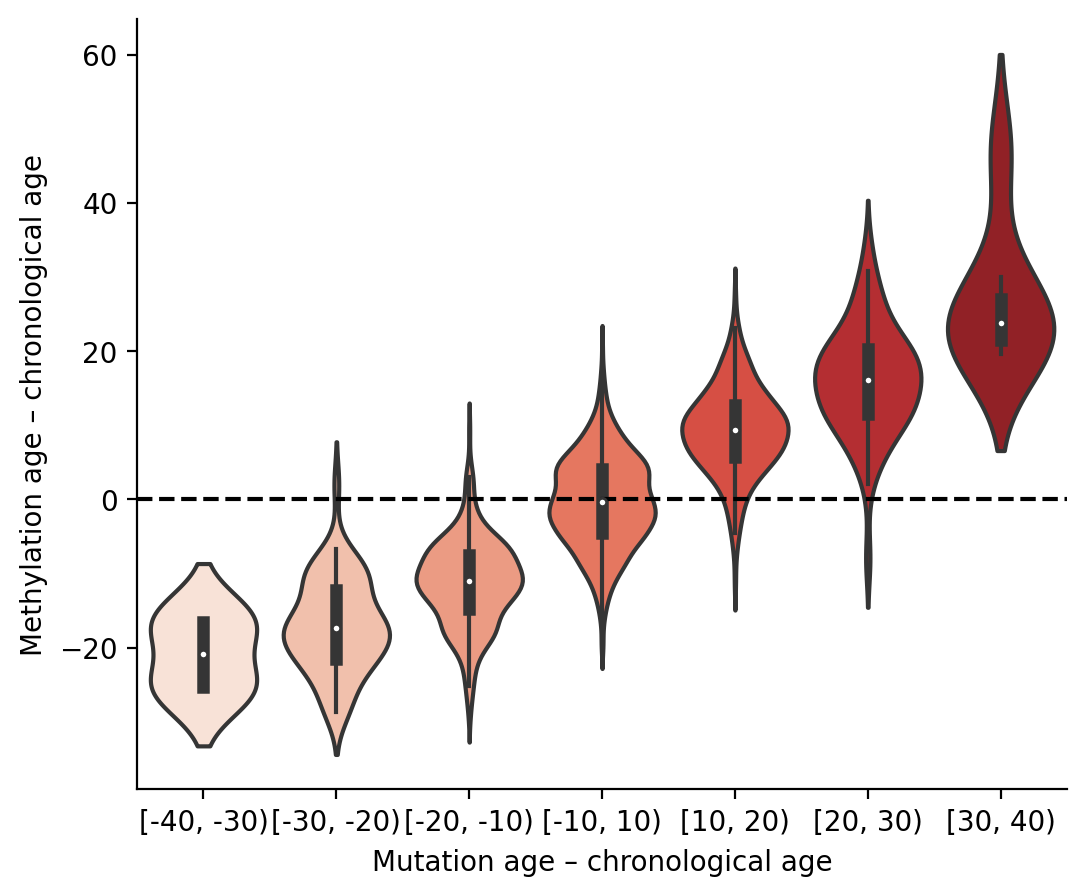

In [176]:
# convert to z score within each age bin
#chosen_tissues = ['PRAD', 'LGG', 'KIRP', 'SARC', 'THYM', 'GBM', 'BLCA']
# bin into standard deviation bins
mut_clock_cpg_binary.mut_count_w_pred_results_df['mut_clock_resid_bin'] = mut_clock_cpg_binary.mut_count_w_pred_results_df.query(
    "this_cv_test_sample == True and tissue in @chosen_tissues"
    )['mut_clock_resid'].transform(lambda x: pd.cut(x, bins = [-40, -30, -20, -10, 10, 20, 30, 40], right=False, duplicates = 'drop',))

fig, axes = plt.subplots(figsize = (6, 5))
sns.violinplot(
    data = mut_clock_cpg_binary.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True and tissue in @chosen_tissues"
            ), x='mut_clock_resid_bin', y = 'methyl_clock_resid', ax = axes, palette='Reds',
            scale='width'
            )
axes.set_ylabel('Methylation age – chronological age')
axes.set_xlabel('Mutation age – chronological age')
# plot y = 0 axhline
plt.axhline(y = 0, color = 'black', linestyle = '--')
sns.despine()

#pearson_r = pearsonr(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['somage_residual'], mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['residual'])[0]
#plt.annotate(f"Pearson r = {pearson_r:.2f}", xy = (0.05, 0.9), xycoords = 'axes fraction')
# add pvalue too
#pearson_p = pearsonr(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['somage_residual'], mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['residual'])[1]
#plt.annotate(f"p = {pearson_p:.2e}", xy = (0.05, 0.85), xycoords = 'axes fraction')

# Fig 5 variance explained bar

In [ ]:
# explaining age

var_explained = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[
    ['age_at_index', 'pred_age', 'soMage_all_feats_wg', 'log_wg_burden']
    ].corr(method = 'pearson').iloc[0, :]

var_explained['tissue'] = 'All'
# get variance explained by tissue
var_explained_by_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue')[
    ['age_at_index', 'pred_age', 'soMage_all_feats_wg', 'log_wg_burden']
    ].corr(method = 'pearson').iloc[0::4, :]
var_explained_by_tissue.reset_index(inplace = True)
var_explained_to_plot = var_explained_by_tissue.append(var_explained, ignore_index = True)

var_explained_to_plot.drop(columns = ['level_1', 'age_at_index'], inplace = True)
var_explained_to_plot.set_index('tissue', inplace = True)
var_explained_to_plot = var_explained_to_plot.stack().to_frame().reset_index(drop = False).rename(columns = {0:'var_explained', 'level_1':'model'})


In [ ]:
# explaining epi age

epi_var_explained = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[
    ['pred_age', 'age_at_index', 'soMage_all_feats_wg', 'log_wg_burden' ]
    ].corr(method = 'pearson').iloc[0, :]

epi_var_explained['tissue'] = 'All'
# get variance explained by tissue
epi_var_explained_by_tissue = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('tissue')[
    ['pred_age', 'age_at_index', 'soMage_all_feats_wg', 'log_wg_burden']
    ].corr(method = 'pearson').iloc[0::4, :]
epi_var_explained_by_tissue.reset_index(inplace = True)
epi_var_explained_to_plot = epi_var_explained_by_tissue.append(epi_var_explained, ignore_index = True)

epi_var_explained_to_plot.drop(columns = ['level_1', 'pred_age'], inplace = True)
epi_var_explained_to_plot.set_index('tissue', inplace = True)
epi_var_explained_to_plot = epi_var_explained_to_plot.stack().to_frame().reset_index(drop = False).rename(columns = {0:'var_explained', 'level_1':'model'})

In [ ]:
# map to new names
names_map = {
    'pred_age': 'Methylation clock',
    'age_at_index': 'Chronological age',
    'soMage_all_feats_wg': 'Mutation clock',
    'log_wg_burden': 'Whole genome mutation burden',
    }
var_explained_to_plot['model'] = var_explained_to_plot['model'].map(names_map)
epi_var_explained_to_plot['model'] = epi_var_explained_to_plot['model'].map(names_map)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (14, 6), sharey=True)

hue_order = ['All', 'Brain', 'Colon', 'Liver', 'Cervix', 'Thyroid', 'Uterus', 'Breast']

x_order = ['Mutation clock', 'Methylation clock', 'Whole genome mutation burden']

sns.barplot(
    var_explained_to_plot, x= 'model', y = 'var_explained', hue = 'tissue',
    palette = my_palette, ax = axes[0], hue_order = hue_order, order = x_order,
    edgecolor = 'black'
)
axes[0].set_xlabel('r^2 with chronological\nage')
# move legend outside plot to right
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# angle x tick labels
#_ = axes[0].set_xticklabels(axes[0].get_xticklabels(),ha = 'left')

x_order = ['Mutation clock','Chronological age',  'Whole genome mutation burden']

sns.barplot(
    epi_var_explained_to_plot, x= 'model', y = 'var_explained', hue = 'tissue',
    palette = my_palette, ax = axes[1], hue_order = hue_order, order = x_order,
    edgecolor = 'black'
)

sns.despine()
axes[0].set_ylabel('Pearson r with Chronological age')

axes[1].set_ylabel('Pearson r with Methylation Age')
#_ = axes[1].set_xticklabels(axes[1].get_xticklabels(),  ha = 'left')
sns.despine()
# remove legend
axes[1].legend().remove()
# remove x axis label
axes[1].set_xlabel('')
axes[0].set_xlabel('')
# set y min to 0
axes[0].set_ylim(0, .9)
axes[1].set_ylim(0, .9)
plt.tight_layout()
plt.savefig(f"{fig_out_dir}/var_explained_barplot.svg", dpi = 300, format = 'svg')

In [ ]:
epi_var_explained = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[
    ['pred_age', 'age_at_index', 'soMage_all_feats_wg', ]
    ].corr(method = 'pearson').iloc[0, :]**2
epi_var_explained

In [ ]:
pred_vs_age = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("pred_age ~ age_at_index", tissue = 'all', pred_name = '')
pred_vs_age_and_somage = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("pred_age ~ age_at_index + soMage_all_feats_wg", tissue = 'all', pred_name = '')
pred_vs_age_and_somage.compare_lr_test(pred_vs_age)

In [ ]:
age_vs_pred_age = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("age_at_index ~ pred_age", tissue = 'all', pred_name = '')
age_vs_pred_age_and_somage = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("age_at_index ~ soMage_all_feats_wg + pred_age", tissue = 'all', pred_name = '')
age_vs_pred_age_and_somage.compare_lr_test(age_vs_pred_age)

# 5h: age accel across existing clocks

In [ ]:
# combine all into one df
mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df['Clock'] = 'Hannum'
mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df['Clock'] = 'PhenoAge'
mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df['Clock'] = 'Horvath-2013'
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['Clock'] = 'PanCan'
all_clocks_pred_results_df = pd.concat([ mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['Clock', 'pred_age']], mut_clock_tcga_hunnidk_all_tenkb_hannum.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['Clock', 'pred_age']], mut_clock_tcga_hunnidk_all_tenkb_phenoage.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['Clock', 'pred_age']], mut_clock_tcga_hunnidk_all_tenkb_horvath.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['Clock', 'pred_age']]], axis = 0)

all_clocks_pred_results_df.reset_index(drop = False, inplace = True)

all_clocks_pred_results_df['mutation_age'] = all_clocks_pred_results_df['index'].map(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['soMage_all_feats_wg'])
all_clocks_pred_results_df['age_at_index'] = all_clocks_pred_results_df['index'].map(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['age_at_index'])
all_clocks_pred_results_df.set_index('index', inplace = True)

all_clocks_pred_results_df['residual'] = all_clocks_pred_results_df['pred_age'] - all_clocks_pred_results_df['age_at_index']

bin_size = 5
all_clocks_pred_results_df['age_bin'] = pd.cut(
    all_clocks_pred_results_df['age_at_index'], 
    bins = [x for x in range(20, 90, bin_size)], 
    labels = [f'{i} - {i+bin_size}' for i in range(20, 90-bin_size, bin_size)]
    )


In [ ]:
all_clocks_pred_results_df['methylation_age_within_age_bin'] = all_clocks_pred_results_df.groupby('age_bin')['mutation_age'].transform(lambda x: pd.qcut(x, q = 5, duplicates = 'drop', labels = ['Low', '1','2', '3', 'High']))
all_clocks_pred_results_df['methylation_age_within_age_bin'] = all_clocks_pred_results_df['methylation_age_within_age_bin'].astype(str)

#mlap = {'1': 'Intermediate', '2': 'Intermediate', '3': 'Intermediate', 'Low': 'Low', 'High': 'High'}
#all_clocks_pred_results_df['methylation_age_within_age_bin'] = all_clocks_pred_results_df['methylation_age_within_age_bin'].map(mlap)
all_clocks_pred_results_df = all_clocks_pred_results_df.query('methylation_age_within_age_bin == "Low" or methylation_age_within_age_bin == "High"')
all_clocks_pred_results_df['clock_plus_bin'] = all_clocks_pred_results_df['Clock'] + '_' + all_clocks_pred_results_df['methylation_age_within_age_bin']

In [ ]:
all_clocks_pred_results_df.groupby('clock_plus_bin')['residual'].describe()

In [ ]:
g = sns.FacetGrid(
    all_clocks_pred_results_df, row='Clock', hue='clock_plus_bin', hue_order=['PanCan_High', 'PanCan_Low', 'Hannum_High',  'Hannum_Low', 'PhenoAge_High', 'PhenoAge_Low', 'Horvath-2013_High', 'Horvath-2013_Low'], aspect=6, height=2,palette = ['black',  'grey',  'steelblue', 'skyblue','maroon', 'lightcoral', 'darkgoldenrod', 'wheat'])
    #aspect=6, height=2,)# palette = ['black', 'grey',  'steelblue', 'skyblue','maroon', 'lightcoral', 'darkgoldenrod', 'wheat']
    

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'residual',
      bw_adjust=1, clip_on=False,
      # different palette for each plot
      fill=True, alpha=0.7, linewidth=1.5,
      hue_order = ['Low',  'High'],
      )

g.fig.subplots_adjust(hspace=-1)

# here we add a horizontal line for each plot
g.map(
      plt.axhline, y=0,
      lw=0.0001, clip_on=False, alpha = 1
      )

# we loop over the FacetGrid figure axes (g.axes.flat) and add the clock as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
clock_dict ={
    1: 'PanCan',
    2: 'Hannum',
    3: 'PhenoAge',
    4: 'Horvath',
}

# t-test between high and low within each clock
from scipy.stats import ttest_ind

p_vals = []
mean_diffs = []
for clock in all_clocks_pred_results_df['Clock'].unique():
    print(clock)
    p_vals.append(ttest_ind(
        all_clocks_pred_results_df.query(f'Clock == "{clock}" and methylation_age_within_age_bin == "High"')['residual'],
        all_clocks_pred_results_df.query(f'Clock == "{clock}" and methylation_age_within_age_bin == "Low"')['residual']
        ).pvalue)
    # difference of means
    mean_diffs.append(float(all_clocks_pred_results_df.query(f'Clock == "{clock}" and methylation_age_within_age_bin == "High"')['residual'].mean() - all_clocks_pred_results_df.query(f'Clock == "{clock}" and methylation_age_within_age_bin == "Low"')['residual'].mean()))

for i, ax in enumerate(g.axes.flat):
    ax.text(-40, 0.01, clock_dict[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    # also add p value and mean difference
    ax.text(-40, 0.005, f"p = {p_vals[i]:.2e}",
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())
    ax.text(-40, 0.0025, f"mean diff = {mean_diffs[i]:.2f}",
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())
    

# eventually we remove axes titles, yticks and spines
g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=False)
# save to svg
plt.savefig(f"{fig_out_dir}/all_clocks_SomEpiAge_vs_residuals_ridgeline.svg", dpi = 300, format = 'svg')

# Supp: clock crossover analysis

In [ ]:
# need correlations of 1. mutation burdens with age, 2. methylation with age (do just in time bc otherwise will be calculating across test)
# then selecting from the opposite, train an xgboost clock on the other and observe performance
# if selecting based on correlation of one with age leads to a good predictor of other with age, this is evidence of an interrelation 

In [ ]:
mut_burden_matrix = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("cv_number == 0").iloc[:, :-38].copy(deep = True)
mut_burden_matrix.drop(columns = 'sum', inplace = True)
# add tissue column
mut_burden_matrix['tissue'] = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("cv_number == 0")['tissue']

In [ ]:
methyl_matrix = all_methyl_age_df_t.loc[mut_burden_matrix.index, mut_burden_matrix.columns[:-3]].copy(deep = True)
# add in age and dataset and gender
methyl_matrix['age_at_index'] =  all_methyl_age_df_t.loc[mut_burden_matrix.index,'age_at_index']
methyl_matrix['tissue'] =  all_methyl_age_df_t.loc[mut_burden_matrix.index,'dataset']
methyl_matrix['gender'] = all_methyl_age_df_t.loc[mut_burden_matrix.index,'gender']

##### Directly comparing MI values

In [ ]:
cv_num = 0
mut_burden_mutual_info_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/mut_burden_mi_cv{cv_num}.parquet")
methyl_mutual_info_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/methyl_mi_cv{cv_num}.parquet")
#  merge on index

In [ ]:
mi_df = pd.merge(mut_burden_mutual_info_df, methyl_mutual_info_df, left_index = True, right_index = True, suffixes = ('_mut_burden', '_methyl'))

In [ ]:
# bin into 100 bins by mutual_info_mut_burden
mi_df['mut_mi_bin'] = pd.qcut(mi_df['mutual_info_mut_burden'], q = 10, duplicates = 'drop', )
mi_df['methyl_mi_bin'] = pd.qcut(mi_df['mutual_info_methyl'], q = 10, duplicates = 'drop', )


In [ ]:
mi_df.groupby('mut_mi_bin')['mutual_info_mut_burden'].describe()

In [ ]:
sns.boxplot(data = mi_df, x = 'methyl_mi_bin', y = 'mutual_info_mut_burden', showfliers = False)

In [ ]:
sns.boxplot(data = mi_df, x = 'mut_mi_bin', y = 'mutual_info_methyl')

In [ ]:
plt.hexbin(mi_df['mutual_info_mut_burden'], mi_df['mutual_info_methyl'], gridsize=50, cmap='inferno', bins = 'log')

##### select by mutation

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb

all_select_by_burden_predict_by_methyl_dfs = []
step_size = 10000
overlap = 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# do split
cv_num = 0
for train_index, test_index in skf.split(mut_burden_matrix.iloc[:,:-3], mut_burden_matrix['age_at_index']):
    X_train, y_train = mut_burden_matrix.iloc[train_index, :-3], mut_burden_matrix.iloc[train_index]['age_at_index']
    X_test, y_test = mut_burden_matrix.iloc[test_index, :-3], mut_burden_matrix.iloc[test_index]['age_at_index']

    try:
        mutual_info_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/mut_burden_mi_cv{cv_num}.parquet")
    except:
        mutual_infos = mutual_info_regression(X_train, y_train,  random_state=42)
        mutual_info_df = pd.DataFrame({'mutual_info': mutual_infos}, index = X_train.columns)
        # sort by mutual info
        mutual_info_df.sort_values(by = 'mutual_info', ascending = False, inplace = True)
        mutual_info_df.to_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/mut_burden_mi_cv{cv_num}.parquet")
    
    corrs = []
    maes = []
    for num_top_corrs in range(0, 100000, step_size):
        # select the top 1000
        selected_sites = mutual_info_df[num_top_corrs:num_top_corrs+step_size].index
        # select these as training features from methyl matrix
        X_train_methyl = methyl_matrix.loc[X_train.index, selected_sites]
        y_train_methyl = methyl_matrix.loc[X_train.index, 'age_at_index']
        X_test_methyl = methyl_matrix.loc[X_test.index, selected_sites]
        y_test_methyl = methyl_matrix.loc[X_test.index, 'age_at_index']
        # train an xgboost regressor
        xgb_reg = xgb.XGBRegressor(
            objective = 'reg:squarederror',
            learning_rate = 0.1, n_jobs = -1
            )
        xgb_reg.fit(X_train_methyl, y_train_methyl)
        # predict on test
        y_pred = xgb_reg.predict(X_test_methyl)
        r = pearsonr(y_pred, y_test_methyl).statistic
        mae = np.mean(np.abs(y_pred - y_test_methyl))
        corrs.append(r)
        maes.append(mae)
        print(num_top_corrs, flush = True)
    select_by_burden_predict_by_methyl_df = pd.DataFrame({'sites_chosen_start': [x for x in range(0, 100000, step_size)], 'r': corrs, 'mae': maes})
    select_by_burden_predict_by_methyl_df['cv_num'] = cv_num
    all_select_by_burden_predict_by_methyl_dfs.append(select_by_burden_predict_by_methyl_df)
    cv_num += 1
all_select_by_burden_predict_by_methyl_df = pd.concat(all_select_by_burden_predict_by_methyl_dfs, axis = 0)
all_select_by_burden_predict_by_methyl_df.to_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/all_select_by_mutburden_predict_by_methyl_clock_perf_df_{step_size}NumSiteClocks.parquet")

In [ ]:
all_select_by_burden_predict_by_methyl_df_l = []
for step_size_name, step_size in zip(["", "_10000NumSiteClocks", "_50000NumSiteClocks"], [1000, 10000, 50000]):
    all_select_by_burden_predict_by_methyl_df_one_step = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/all_select_by_mutburden_predict_by_methyl_clock_perf_df{step_size_name}.parquet")
    all_select_by_burden_predict_by_methyl_df_one_step['num_sites'] = step_size
    all_select_by_burden_predict_by_methyl_df_l.append(all_select_by_burden_predict_by_methyl_df_one_step)
all_select_by_burden_predict_by_methyl_df = pd.concat(all_select_by_burden_predict_by_methyl_df_l, axis = 0)

In [ ]:
all_select_by_burden_predict_by_methyl_df.groupby(['num_sites'])['sites_chosen_start', 'r'].corr(method = 'spearman')

In [ ]:
all_select_by_burden_predict_by_methyl_df.query("num_sites == 10000").groupby(['num_sites', 'sites_chosen_start']).describe()

In [ ]:
# bin sites_chosen_start into bins
all_select_by_burden_predict_by_methyl_df['bins'] = pd.cut(all_select_by_burden_predict_by_methyl_df['sites_chosen_start'], bins = [0, 10000, 90000, 100000], right = False, labels = ['Top 10%', 'Middle 80%', 'Bottom 10%'])

In [ ]:
sns.barplot(data = all_select_by_burden_predict_by_methyl_df, x = 'bins', y = 'r', capsize = .1, errorbar=('ci', 95), palette = ['grey', 'darkgrey', 'lightgrey'])
#sns.swarmplot(data = all_select_by_methyl_predict_by_mut_df, x = 'bins', y = 'r', color='black')
plt.xlabel('Genomic regions (20kb) sets with decreasing mutation burden age-association')
plt.ylabel('Pearson correlation of methylation clock prediction\nwith chronological age')
plt.ylim(0.6, 0.66)

spearman_res = spearmanr(all_select_by_burden_predict_by_methyl_df['r'], all_select_by_burden_predict_by_methyl_df['sites_chosen_start'])
# add spearman r and p value to plot upper right
plt.annotate(f"Spearman r = {spearman_res.correlation:.2f}", xy = (0.65, 0.9), xycoords = 'axes fraction')
plt.annotate(f"p = {spearman_res.pvalue:.2e}", xy = (0.65, 0.85), xycoords = 'axes fraction')
plt.savefig(f"{fig_out_dir}/select_by_burden_predict_by_methyl_clock_perf.svg", dpi = 300, format = 'svg')

In [ ]:
all_select_by_burden_predict_by_methyl_df.query("sites_chosen_start < 10000").describe()

In [ ]:
all_select_by_burden_predict_by_methyl_df.query("sites_chosen_start > 90000").describe()

##### select by methylation

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb

all_select_by_methyl_predict_by_mut_dfs = []
step_size = 10000
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# do split
cv_num = 0
for train_index, test_index in skf.split(methyl_matrix.iloc[:,:-3], methyl_matrix['age_at_index']):
    X_train, y_train = methyl_matrix.iloc[train_index, :-3], methyl_matrix.iloc[train_index]['age_at_index']
    X_test, y_test = methyl_matrix.iloc[test_index, :-3], methyl_matrix.iloc[test_index]['age_at_index']

    try:
        mutual_info_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/methyl_mi_cv{cv_num}.parquet")
    except:
        mutual_infos = mutual_info_regression(X_train, y_train,  random_state=42)
        mutual_info_df = pd.DataFrame({'mutual_info': mutual_infos}, index = X_train.columns)
        # sort by mutual info
        mutual_info_df.sort_values(by = 'mutual_info', ascending = False, inplace = True)
        mutual_info_df.to_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/methyl_mi_cv{cv_num}.parquet")
    
    corrs = []
    maes = []
    for num_top_corrs in range(0, 100000, step_size):
        # select the top 1000
        selected_sites = mutual_info_df[num_top_corrs:num_top_corrs+step_size].index
        # select these as training features from methyl matrix
        X_train_mut = mut_burden_matrix.loc[X_train.index, selected_sites]
        y_train_mut = mut_burden_matrix.loc[X_train.index, 'age_at_index']
        X_test_mut = mut_burden_matrix.loc[X_test.index, selected_sites]
        y_test_mut = mut_burden_matrix.loc[X_test.index, 'age_at_index']
        # train an xgboost regressor
        xgb_reg = xgb.XGBRegressor(
            objective = 'reg:squarederror',
            learning_rate = 0.1, n_jobs = -1
            )
        xgb_reg.fit(X_train_mut, y_train_mut)
        # predict on test
        y_pred = xgb_reg.predict(X_test_mut)
        r = pearsonr(y_pred, y_test_mut).statistic
        mae = np.mean(np.abs(y_pred - y_test_mut))
        corrs.append(r)
        maes.append(mae)
        print(num_top_corrs, flush = True)
    select_by_methyl_predict_by_mut_df = pd.DataFrame({'sites_chosen_start': [x for x in range(0, 100000, step_size)], 'r': corrs, 'mae': maes})
    select_by_methyl_predict_by_mut_df['cv_num'] = cv_num
    all_select_by_methyl_predict_by_mut_dfs.append(select_by_methyl_predict_by_mut_df)
    cv_num += 1
all_select_by_methyl_predict_by_mut_df = pd.concat(all_select_by_methyl_predict_by_mut_dfs, axis = 0)
all_select_by_methyl_predict_by_mut_df.to_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/all_select_by_methyl_predict_by_mut_clock_perf_{step_size}NumSiteClocks.parquet")

In [ ]:
all_select_by_methyl_predict_by_mut_df_l = []
for step_size_name, step_size in zip(["", "_10000NumSiteClocks", "_50000NumSiteClocks"], [1000, 10000, 50000]):
    all_select_by_methyl_predict_by_mut_df_one_step = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_mutual_infos/all_select_by_methyl_predict_by_mut_clock_perf{step_size_name}.parquet")
    all_select_by_methyl_predict_by_mut_df_one_step['num_sites'] = step_size
    all_select_by_methyl_predict_by_mut_df_l.append(all_select_by_methyl_predict_by_mut_df_one_step)
all_select_by_methyl_predict_by_mut_df = pd.concat(all_select_by_methyl_predict_by_mut_df_l, axis = 0)

In [ ]:
all_select_by_methyl_predict_by_mut_df.query("num_sites == 10000").groupby(['num_sites', 'sites_chosen_start'])['mae'].describe()

In [ ]:
all_select_by_methyl_predict_by_mut_df.groupby(['num_sites'])['sites_chosen_start', 'r'].corr(method = 'spearman')

In [ ]:
spearmanr(all_select_by_methyl_predict_by_mut_df.query("num_sites == 10000")['mae'], all_select_by_methyl_predict_by_mut_df.query("num_sites == 10000")['sites_chosen_start'])

In [ ]:
spearmanr(all_select_by_methyl_predict_by_mut_df['r'], all_select_by_methyl_predict_by_mut_df['sites_chosen_start'])

In [ ]:
pearsonr(all_select_by_methyl_predict_by_mut_df['r'], all_select_by_methyl_predict_by_mut_df['sites_chosen_start'])

In [ ]:
all_select_by_methyl_predict_by_mut_df.corr(method = 'spearman')

In [ ]:
# bin sites_chosen_start into bins
all_select_by_methyl_predict_by_mut_df['bins'] = pd.cut(all_select_by_methyl_predict_by_mut_df['sites_chosen_start'], bins = [0, 10000, 90000, 100000], right = False, labels = ['Top 10%', 'Middle 80%', 'Bottom 10%'])

In [ ]:
fig_out_dir

In [ ]:
sns.barplot(data = all_select_by_methyl_predict_by_mut_df, x = 'bins', y = 'r', capsize = .1, errorbar=('ci', 95), palette = ['grey', 'darkgrey', 'lightgrey'])
#sns.swarmplot(data = all_select_by_methyl_predict_by_mut_df, x = 'bins', y = 'r', color='black')
plt.xlabel('CpG sets with decreasing CpGm age-association')
plt.ylabel('Pearson correlation of mutation clock prediction\nwith chronological age')
plt.ylim(0.1, 0.26)
spearman_res = spearmanr(all_select_by_methyl_predict_by_mut_df['r'], all_select_by_methyl_predict_by_mut_df['sites_chosen_start'])
# add spearman r and p value to plot upper right
plt.annotate(f"Spearman r = {spearman_res.correlation:.2f}", xy = (0.65, 0.9), xycoords = 'axes fraction')
plt.annotate(f"p = {spearman_res.pvalue:.2e}", xy = (0.65, 0.85), xycoords = 'axes fraction')
plt.savefig(f"{fig_out_dir}/select_by_methyl_predict_by_mut_clock_perf.svg", dpi = 300, format = 'svg')

# Supp: feature importance analysis

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'age_at_index',
        output_col_label = 'soMage_all_feats_wg_new',
        include_tissue_covariate = False,
        include_wg_burden_covariate = True,
        just_clock_cpgs = False,
        specific_features = [],
        model_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow",
        )

In [ ]:
# read in models for epi clock
import pickle
epi_models = {}
epi_models_coefs = {}
xgb_models = {}
xgb_models_feat_imports = {}
for cv_num in range(5):
    epi_models[cv_num] = pickle.load(open(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/well_pred_BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_enet_model{cv_num}.pkl", 'rb'))
    # get coefficients
    epi_models_coefs[cv_num] = epi_models[cv_num].coef_
    epi_models_coefs[cv_num] = np.append(epi_models_coefs[cv_num], 0)
    
    xgb_models[cv_num] = pickle.load(open(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/082823_residual_burden/100k_cpgs_moreTissues_QnormMethyl_10kbWindow/BRCA_CESC_COAD_LGG_LIHC_THCA_UCEC_xgb_model{cv_num}.pkl", 'rb'))
    # get feature importances
    f_names = [f"f{i}" for i in range(1, 100001)]
    xgb_models_feat_imports[cv_num] = xgb_models[cv_num].get_booster().get_score(importance_type='total_gain')
    # for f_names not in xgb_models_feat_imports[cv_num].keys() add 0 for that feature importance
    for f_name in f_names:
        if f_name not in xgb_models_feat_imports[cv_num].keys():
            xgb_models_feat_imports[cv_num][f_name] = 0
    # convert to inner dictionary to list, sorting in order of feature name
    xgb_models_feat_imports[cv_num] = [xgb_models_feat_imports[cv_num][f_name] for f_name in sorted(xgb_models_feat_imports[cv_num].keys(), key = lambda x: int(x[1:]))]
    
    
feat_names = epi_models[0].feature_names_in_
feat_names = np.append(feat_names, 'sum')

feat_names_repeated = []
for i in range(5):
    feat_names_repeated.extend(feat_names)

# put all feature importances into one df
xgb_feat_imports_df = pd.DataFrame.from_dict(xgb_models_feat_imports, orient = 'columns')
# stack and assign cv_num
xgb_feat_imports_df = xgb_feat_imports_df.stack().to_frame().reset_index(drop = True).rename(columns = {0:'feature_importance', 'level_1':'cv_num'})
xgb_feat_imports_df['cv_num'] = [i for i in range(5) for j in range(100001)]
# set feature names by repeating feat_names 5 times
xgb_feat_imports_df['feat_name'] = feat_names_repeated
xgb_feat_imports_df['model'] = 'mutation_clock'

#xgb_feat_imports_df['feature'] = xgb_feat_imports_df['level_0'].map(epi_models[cv_num].feature_names_in_order)


# put all coefficients into one df
enet_coefs_df = pd.DataFrame.from_dict(epi_models_coefs, orient = 'columns')
# stack and assign cv_num
enet_coefs_df = enet_coefs_df.stack().to_frame().reset_index(drop = True).rename(columns = {0:'coef', 'level_1':'cv_num'})
enet_coefs_df['cv_num'] = [i for i in range(5) for j in range(100001)]
enet_coefs_df['feat_name'] = feat_names_repeated
enet_coefs_df['model'] = 'epi_clock'

# join on cv_num and feat_name
feat_imports_df = pd.merge(xgb_feat_imports_df, enet_coefs_df, on = ['cv_num', 'feat_name'], how = 'outer')
    

In [ ]:
enet_coefs_df.query("coef != 0")['cv_num'].value_counts().describe()

In [ ]:
xgb_feat_imports_df.query("feature_importance > 0")['cv_num'].value_counts().describe()

In [ ]:
nonzero_epi_clock_features = feat_imports_df.query("coef != 0").groupby('cv_num').count().iloc[:,0]
nonzero_mut_clock_features = feat_imports_df.query("feature_importance != 0").groupby('cv_num').count().iloc[:,0]
nonzero_shared_features = feat_imports_df.query("feature_importance != 0 and coef ! = 0").groupby('cv_num').count().iloc[:,0]


# combine
nonzero_features = pd.concat([nonzero_epi_clock_features, nonzero_mut_clock_features, nonzero_shared_features], axis = 1)
nonzero_features.columns = ['epi_clock', 'mutation_clock', 'shared']
nonzero_features = nonzero_features/100001

# get expected shared features if random
nonzero_features['expected_shared_if_rand'] = nonzero_features['epi_clock'] * nonzero_features['mutation_clock']

# import binomial test
from scipy.stats import binom_test
# do binomial test for each cv
nonzero_features['p_value'] = nonzero_features.apply(lambda x: binom_test(x['shared'], n = 100001, p = x['expected_shared_if_rand']), axis = 1)
nonzero_features['effect_size'] = nonzero_features['shared'] - nonzero_features['expected_shared_if_rand']

nonzero_features

In [ ]:
feat_imports_df.query("coef != 0").shape[0] / 5

In [ ]:
(nonzero_shared_features - expected_if_rand) /expected_if_rand

In [ ]:
expected_if_rand

In [ ]:
nonzero_epi_clock_features = feat_imports_df.query("coef != 0").shape[0] / 500005
nonzero_mut_clock_features = feat_imports_df.query("feature_importance != 0").shape[0] / 500005
nonzero_shared_features = feat_imports_df.query("feature_importance != 0 and coef ! = 0").shape[0] / 500005
expected_if_rand = nonzero_epi_clock_features * nonzero_mut_clock_features
print(f"p-value for shared features: {binom_test(nonzero_shared_features, n = 500005, p = expected_if_rand)}")
print(f"effect size for shared features (actual – expected): {nonzero_shared_features - expected_if_rand}")
print("number of nonzero features in epi clock on avg: ", 100001 * nonzero_epi_clock_features)
print("number of nonzero features in mut clock on avg: ", 100001 * nonzero_mut_clock_features)
print("number of shared nonzero features on avg: ", 100001 * nonzero_shared_features)
print("expected number of shared nonzero features if random: ", 100001 * expected_if_rand)

In [ ]:
# total_gain
pearsonr(feat_imports_df.query("feature_importance != 0 and coef ! = 0")['coef'].abs(), feat_imports_df.query("feature_importance != 0 and coef ! = 0")['feature_importance'])

In [ ]:
# weight 
pearsonr(feat_imports_df.query("feature_importance != 0 and coef ! = 0")['coef'].abs(), feat_imports_df.query("feature_importance != 0 and coef ! = 0")['feature_importance'])


In [ ]:
# gain
pearsonr(feat_imports_df.query("feature_importance != 0 and coef ! = 0")['coef'].abs(), feat_imports_df.query("feature_importance != 0 and coef ! = 0")['feature_importance'])



In [ ]:
all_feat_mat = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns[:10001]]
# convert to csr matrix
from scipy.sparse import csr_matrix
#all_feat_mat = csr_matrix(all_feat_mat.values)

In [ ]:
explainer.shap_values(
        all_feat_mat
    )

# Supp: clock mutation burden vs WGMB vs random choices

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("pred_age ~ wg_burden", tissue = 'all', pred_name = 'pred_age ~ wg_burden') 
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['pred_age', 'pred_age ~ wg_burden']].corr(method = 'pearson')

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.fit_linear_model("pred_age ~ log_wg_burden", tissue = 'all', pred_name = 'pred_age ~ log_wg_burden')

mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")[['pred_age', 'pred_age ~ log_wg_burden']].corr(method = 'pearson')

In [ ]:
import random

all_clock_cpgs = []
for clock_cpgs in mut_clock_tcga_hunnidk_all_tenkb_pancan_big.clock_cpgs_by_tissue.values():
    all_clock_cpgs.extend(clock_cpgs)
all_clock_cpgs = list(set(all_clock_cpgs))

possible_features = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns[
                        mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns.str.startswith('cg') 
                        | mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns.str.startswith('ch')
                        ].tolist()
possible_features = list(set(possible_features) - set(all_clock_cpgs))

num_features_to_choose = 6013
for random_iter in range(50):
    # choose random features from list
    random_features = random.sample(possible_features, num_features_to_choose)
    mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mutational_age_prediction(
        target = 'pred_age',
        output_col_label = f'random_soMepi_age_{random_iter}',
        include_tissue_covariate = False,
        include_wg_burden_covariate = False,
        just_clock_cpgs = False,
        specific_features = random_features
        )

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df[all_clock_cpgs].stack().describe()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df[possible_features].stack().describe()

In [ ]:
bin_size = 1
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df['age_bin'] = pd.cut(
    mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query(
            "this_cv_test_sample == True"
            )['age_at_index'],
    bins = [x for x in range(25, 85, bin_size)], labels = [f'{i}' for i in range(25, 85-bin_size, bin_size)]
    )

In [ ]:
somepi_corrs = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('age_bin')[['pred_age', 'soMepi_age']].corr(method = 'pearson').iloc[::2, 1]

In [ ]:
somepi_corrs.hist()

In [ ]:
mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.index.nunique()

In [ ]:
random_corrs = mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True").groupby('age_bin')[mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns[mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.columns.str.startswith('random_soMepi_age')]].corrwith(mut_clock_tcga_hunnidk_all_tenkb_pancan_big.mut_count_w_pred_results_df.query("this_cv_test_sample == True")['pred_age'], method = 'pearson')

In [ ]:
random_corrs.mean(axis = 1).hist()

In [ ]:
random_corrs['mean'] = random_corrs.mean(axis = 1)
random_corrs['std'] = random_corrs.std(axis = 1)

# Supp: few-shot training

In [ ]:
horvath_clock = pd.read_csv("/cellar/users/zkoch/other_clocks/horvath.csv", skiprows=2)
pheno_clock = pd.read_csv("/cellar/users/zkoch/other_clocks/phenoAge_clock.csv")
hannum_clock = pd.read_csv("/cellar/users/ayl009/hannum_model.csv")
# get the clock CpGs for each
horvath_cpgs = horvath_clock.loc[1:, 'CpGmarker'].values
pheno_cpgs = pheno_clock.loc[1:, 'CpG'].values
hannum_cpgs = hannum_clock.loc[:, 'Marker'].values
# get the number of CpGs measured in no drop TCGA data
measured_cpgs = all_methyl_age_df_t.columns
horvath_measured_cpgs = set(horvath_cpgs).intersection(set(measured_cpgs))
pheno_measured_cpgs = set(pheno_cpgs).intersection(set(measured_cpgs))  
hannum_measured_cpgs = set(hannum_cpgs).intersection(set(measured_cpgs))
# get the coefficients for each measured CpG
horvath_coefs = horvath_clock.query("CpGmarker in @horvath_measured_cpgs")['CoefficientTraining'].values
hovarth_intercept = horvath_clock.loc[0, 'CoefficientTraining']
pheno_coefs = pheno_clock.query("CpG in @pheno_measured_cpgs")['Weight'].values
pheno_intercept = pheno_clock.loc[0, 'Weight']
hannum_coefs = hannum_clock.query("Marker in @hannum_measured_cpgs")['Coefficient'].values
# do prediction on no drop TCGA data
horvath_pred = (all_methyl_age_df_t.loc[:, horvath_measured_cpgs]).dot(horvath_coefs) + hovarth_intercept
pheno_pred = all_methyl_age_df_t.loc[:, pheno_measured_cpgs].dot(pheno_coefs) + pheno_intercept
hannum_pred = all_methyl_age_df_t.loc[:, hannum_measured_cpgs].dot(hannum_coefs)
# add these as columnbs to no_drop_tcga_methyl_df_t
all_methyl_age_df_t['horvath_pred'] = horvath_pred
all_methyl_age_df_t['pheno_pred'] = pheno_pred
all_methyl_age_df_t['hannum_pred'] = hannum_pred
# print the frraction of CpGs measured in each clock
print(len(horvath_measured_cpgs)/len(horvath_cpgs))
print(len(pheno_measured_cpgs)/len(pheno_cpgs))
print(len(hannum_measured_cpgs)/len(hannum_cpgs))

In [ ]:
order

In [ ]:
pearson_corr_df = all_methyl_age_df_t.groupby('dataset')[['age_at_index', 'horvath_pred', 'pheno_pred', 'hannum_pred']].corr().reset_index().iloc[::4]
# switch to long format
pearson_corr_df = pd.melt(pearson_corr_df, id_vars = ['dataset', 'level_1'], value_vars = ['age_at_index', 'horvath_pred', 'pheno_pred', 'hannum_pred'])
pearson_corr_df.rename(columns = {'variable': 'clock', 'value': 'Pearson r'}, inplace = True)
pearson_corr_df.drop(columns = ['level_1'], inplace = True)
pearson_corr_df = pearson_corr_df.query("clock != 'age_at_index'")
fig, axes = plt.subplots(1,1, figsize = (12,5))
dsets = order[1:]
pearson_corr_df['clock'] = pearson_corr_df['clock'].map({'horvath_pred':'Horvath-2013', 'pheno_pred':'PhenoAge', 'hannum_pred':'Hannum'})
sns.pointplot(data = pearson_corr_df.query("dataset in @dsets"), x = 'dataset', y = 'Pearson r', hue = 'clock', join = True, ax = axes)
# angle x tick labels
axes.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Tissue')
plt.ylabel('Predicted vs. chronological age Pearson r')
plt.savefig(f"{fig_out_dir}/supp_not_retrained_clock_performance.svg", dpi = 300, format = 'svg')

In [ ]:
pearson_corr_df.query("dataset in @dsets").groupby('clock')['Pearson r'].describe()

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))

pearson_corr_df = all_clocks_pred_results_df.groupby(['Clock', 'tissue'])[['age_at_index', 'pred_age']].corr()
pearson_corr_df = pearson_corr_df.reset_index().iloc[::2]

sns.pointplot(data = pearson_corr_df, x = 'tissue', y = 'pred_age', hue = 'Clock', join = True, ax = axes, hue_order=['Horvath-2013', 'PhenoAge', 'Hannum', 'PanCan'])
plt.ylabel('Pearson r')

plt.savefig(f"{fig_out_dir}/supp_retrained_clock_performance.svg", dpi = 300, format = 'svg')

In [ ]:
#mae 
mae_df = all_clocks_pred_results_df.groupby(['Clock', 'tissue'])[['age_at_index', 'pred_age']].apply(lambda x: mean_absolute_error(x['age_at_index'], x['pred_age'])).reset_index()


In [ ]:
order

In [ ]:
mae_df.groupby('Clock')[0].describe()

In [ ]:
pearson_corr_df.groupby('Clock')['pred_age'].describe()